In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import os
import glob
import rioxarray as rio
import rasterio as rio
from pyproj import Transformer
from esda.moran import Moran
from libpysal.weights import lat2W
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from skimage import filters

In [59]:
sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
dfs = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name=sheet_names)
dfs

{'Creamers':      CF_Point       Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
 0         1.0  Creamers-0001    7193915.511    465013.469    134.482   
 1         2.0  Creamers-0002    7193918.897    465011.682    134.302   
 2         3.0  Creamers-0003    7193923.281    465011.427    134.370   
 3         4.0  Creamers-0004    7193927.196    465011.460    134.202   
 4         5.0  Creamers-0005    7193930.739    465010.849    134.077   
 ..        ...            ...            ...           ...        ...   
 124     125.0  CREAMERS-0125    7194401.601    464927.795    137.210   
 125     126.0  CREAMERS-0126    7194405.851    464926.465    137.405   
 126       NaN            NaN            NaN           NaN        NaN   
 127       NaN            NaN            NaN           NaN        NaN   
 128       NaN            NaN            NaN           NaN        NaN   
 
      CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
 0              0.000000            0

In [47]:
df_Creamers = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name='Creamers')

df_Creamers_selected = df_Creamers.iloc[:, 7:16]

df_Creamers_selected_transposed = df_Creamers_selected.transpose()

description_selected = df_Creamers_selected_transposed.describe()

df_Creamers_selected_transposed.to_csv('/Users/Azadeh/df_Creamers_selected_transposed.csv')
description_selected.to_csv('/Users/Azadeh/description_selected.csv')
description_selected


0          1          2          3           4          5    \
count    9.000000   9.000000   9.000000   9.000000    9.000000   9.000000   
mean    86.111111  67.666667  68.111111  70.111111   88.000000  82.111111   
std     20.787282   6.800735   5.441609   3.887301   11.368817   8.237786   
min     59.000000  57.000000  62.000000  64.000000   75.000000  66.000000   
25%     73.000000  64.000000  64.000000  67.000000   76.000000  79.000000   
50%     78.000000  69.000000  67.000000  70.000000   89.000000  82.000000   
75%    105.000000  70.000000  73.000000  72.000000   95.000000  89.000000   
max    121.000000  79.000000  78.000000  77.000000  107.000000  93.000000   

             6          7          8          9    ...        119        120  \
count   9.000000   9.000000   9.000000   9.000000  ...   9.000000   9.000000   
mean   68.000000  63.000000  74.666667  67.555556  ...  91.222222  88.111111   
std     5.830952   4.031129  10.920165   3.609401  ...   7.395569   4.400126   
min    57.000000  58.000000  56.000000  63.000000  ...  76.000000  83.000000   
25%    65.000000  60.000000  65.000000  65.000000  ...  88.000000  84.000000   
50%    68.000000  62.000000  79.000000  68.000000  ...  93.000000  88.000000   
75%    72.000000  66.000000  83.000000  69.000000  ...  96.000000  92.000000   
max    77.000000  70.000000  87.000000  74.000000  ...  99.000000  94.000000   

             121        122        123        124        125  126        127  \
count   9.000000   9.000000   9.000000   9.000000   9.000000  0.0   7.000000   
mean   85.444444  60.555556  68.777778  58.444444  84.666667  NaN  71.852599   
std     4.977728   9.408920   8.257993   5.456902   6.103278  NaN   4.501367   
min    76.000000  48.000000  49.000000  52.000000  75.000000  NaN  64.656000   
25%    83.000000  54.000000  68.000000  54.000000  82.000000  NaN  69.400095   
50%    86.000000  65.000000  69.000000  59.000000  86.000000  NaN  72.384000   
75%    87.000000  66.000000  74.000000  61.000000  89.000000  NaN  75.284000   
max    94.000000  75.000000  76.000000  69.000000  91.000000  NaN  76.560000   

             128  
count   7.000000  
mean   13.720168  
std     2.002072  
min    11.398571  
25%    11.925167  
50%    13.625796  
75%    15.618495  
max    15.929482  

[8 rows x 129 columns]

In [33]:
df_Creamers_selected_transposed

0     1     2     3      4     5     6     7     8     9    \
CF_10_8_14     67.0  70.0  67.0  72.0   76.0  89.0  77.0  70.0  80.0  74.0   
CF_09_29_15    59.0  57.0  62.0  72.0   89.0  85.0  72.0  66.0  83.0  68.0   
CF_10_10_16    73.0  64.0  64.0  69.0   75.0  81.0  70.0  67.0  74.0  68.0   
CF 10_2017     78.0  59.0  63.0  67.0   75.0  75.0  63.0  61.0  56.0  63.0   
CF 10_5_2018   78.0  69.0  65.0  67.0   84.0  79.0  65.0  58.0  65.0  63.0   
CF 10_15_19    86.0  69.0  68.0  73.0   93.0  89.0  68.0  62.0  79.0  67.0   
CF 10_6_20    105.0  79.0  78.0  77.0  107.0  93.0  72.0  64.0  85.0  71.0   
CF 10_2_21    121.0  69.0  73.0  64.0   95.0  66.0  57.0  60.0  63.0  65.0   
CF_9_28_22    108.0  73.0  73.0  70.0   98.0  82.0  68.0  59.0  87.0  69.0   

              ...   119   120   121   122   123   124   125  126       127  \
CF_10_8_14    ...  84.0  87.0  83.0  48.0  66.0  60.0  76.0  NaN  66.97619   
CF_09_29_15   ...  76.0  83.0  76.0  66.0  49.0  52.0  75.0  NaN  64.65600   
CF_10_10_16   ...  88.0  94.0  94.0  66.0  68.0  62.0  89.0  NaN  75.36000   
CF 10_2017    ...  96.0  94.0  87.0  56.0  68.0  59.0  86.0  NaN  71.82400   
CF 10_5_2018  ...  93.0  92.0  87.0  54.0  69.0  52.0  82.0  NaN  72.38400   
CF 10_15_19   ...  99.0  88.0  86.0  75.0  74.0  57.0  89.0  NaN  75.20800   
CF 10_6_20    ...  98.0  88.0  89.0  65.0  75.0  69.0  91.0  NaN  76.56000   
CF 10_2_21    ...  94.0  84.0  85.0  67.0  74.0  61.0  91.0  NaN       NaN   
CF_9_28_22    ...  93.0  83.0  82.0  48.0  76.0  54.0  83.0  NaN       NaN   

                    128  
CF_10_8_14    11.398571  
CF_09_29_15   12.154320  
CF_10_10_16   11.696015  
CF 10_2017    13.625796  
CF 10_5_2018  15.536006  
CF 10_15_19   15.700984  
CF 10_6_20    15.929482  
CF 10_2_21          NaN  
CF_9_28_22          NaN  

[9 rows x 129 columns]

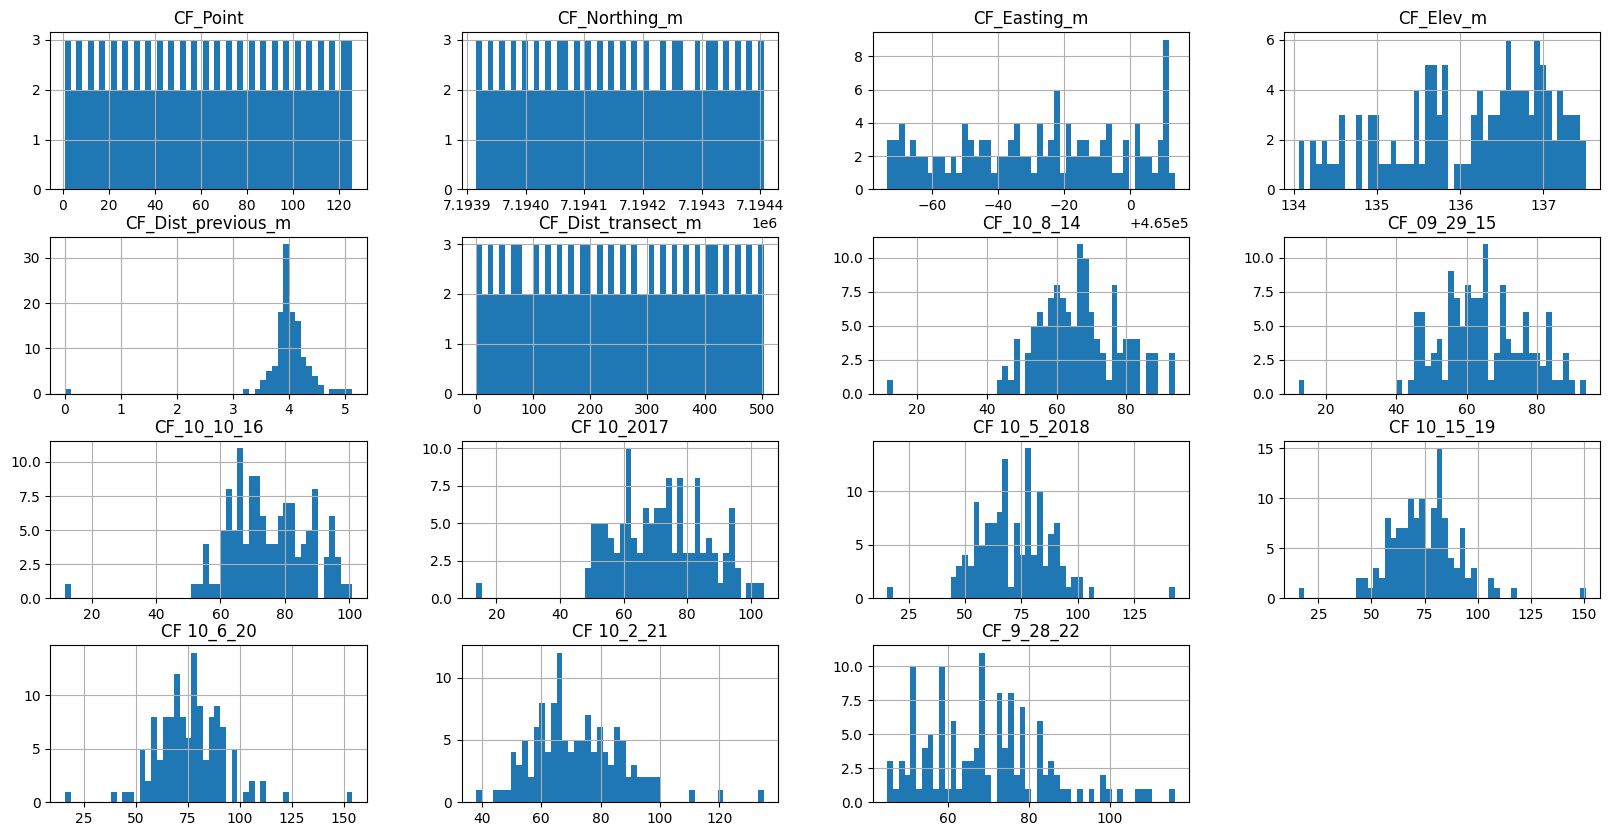

In [61]:
df = pd.read_excel('/Users/Azadeh/CRREL.xlsx')
_ = df.hist(bins=50 , figsize=(20, 10))

In [54]:
def check_missing_values(dfs):
    missing_values_summary = {}
    for sheet_name, dfs in dfs.items():
        missing_values = dfs.isnull().sum()
        missing_values_summary[sheet_name] = missing_values
    return missing_values_summary

missing_values_summary = check_missing_values(dfs)

for sheet_name, missing_values in missing_values_summary.items():
    print(f"Missing values in sheet '{sheet_name}':")
    print(missing_values)
    print("\n")

Missing values in sheet 'Creamers':
CF_Point              3
Point_ID              3
CF_Northing_m         3
CF_Easting_m          3
CF_Elev_m             3
CF_Dist_previous_m    3
CF_Dist_transect_m    3
CF_10_8_14            1
CF_09_29_15           1
CF_10_10_16           1
CF 10_2017            1
CF 10_5_2018          1
CF 10_15_19           1
CF 10_6_20            1
CF 10_2_21            3
CF_9_28_22            3
CF_Notes_22           3
dtype: int64


Missing values in sheet 'Farmers 1':
FL1_Point              28
Point_ID               28
FL1_Northing_m         28
FL1_Easting_m          28
FL1_Elev_m             28
FL1_Dist_previous_m    28
FL1_Dist_transect_m    28
F1_10_7_14             24
F1_09_29_15            24
F1_10_10_16            24
F1 10_3_2017           26
F1 10_10_18            26
FL1_10_14_19           26
FL1_10_5_20            26
9_30_21                26
FL1_9_27_22            28
Type                   28
dtype: int64


Missing values in sheet 'Farmers 2':
FL2_Point 

In [55]:
def display_nan_rows(dfs):
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        
        if not nan_rows.empty:
            print(f"Rows with NaN values in sheet '{sheet_name}':")
            print(nan_rows)
            print("\n")
        else:
            print(f"No NaN values in sheet '{sheet_name}'\n")

display_nan_rows(dfs)


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [56]:
def store_nan_rows(dfs):
    nan_rows_dict = {}
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        nan_rows_dict[sheet_name] = nan_rows
    return nan_rows_dict

nan_rows_dict = store_nan_rows(dfs)

for sheet_name, nan_rows in nan_rows_dict.items():
    if not nan_rows.empty:
        print(f"Rows with NaN values in sheet '{sheet_name}':")
        print(nan_rows)
        print("\n")
    else:
        print(f"No NaN values in sheet '{sheet_name}'\n")


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [57]:
def drop_nan_values(dfs):
    cleaned_dfs = {}
    for sheet_name, df in dfs.items():
        cleaned_df = df.dropna()
        cleaned_dfs[sheet_name] = cleaned_df
    return cleaned_dfs

cleaned_dfs = drop_nan_values(dfs)


In [58]:
new_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

with pd.ExcelWriter(new_file_path) as writer:
    for sheet_name, cleaned_df in cleaned_dfs.items():
        cleaned_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    nan_combined_df = pd.concat(nan_rows_dict, axis=0)
    nan_combined_df.to_excel(writer, sheet_name='NaN_Values', index=True)


In [61]:
for sheet_name, df in dfs.items():
    print(f"Info for sheet '{sheet_name}':")
    print(df.info())
    print("\n")

Info for sheet 'Creamers':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CF_Point            126 non-null    float64
 1   Point_ID            126 non-null    object 
 2   CF_Northing_m       126 non-null    float64
 3   CF_Easting_m        126 non-null    float64
 4   CF_Elev_m           126 non-null    float64
 5   CF_Dist_previous_m  126 non-null    float64
 6   CF_Dist_transect_m  126 non-null    float64
 7   CF_10_8_14          128 non-null    float64
 8   CF_09_29_15         128 non-null    float64
 9   CF_10_10_16         128 non-null    float64
 10  CF 10_2017          128 non-null    float64
 11  CF 10_5_2018        128 non-null    float64
 12  CF 10_15_19         128 non-null    float64
 13  CF 10_6_20          128 non-null    float64
 14  CF 10_2_21          126 non-null    float64
 15  CF_9_28_22          126 non-nu

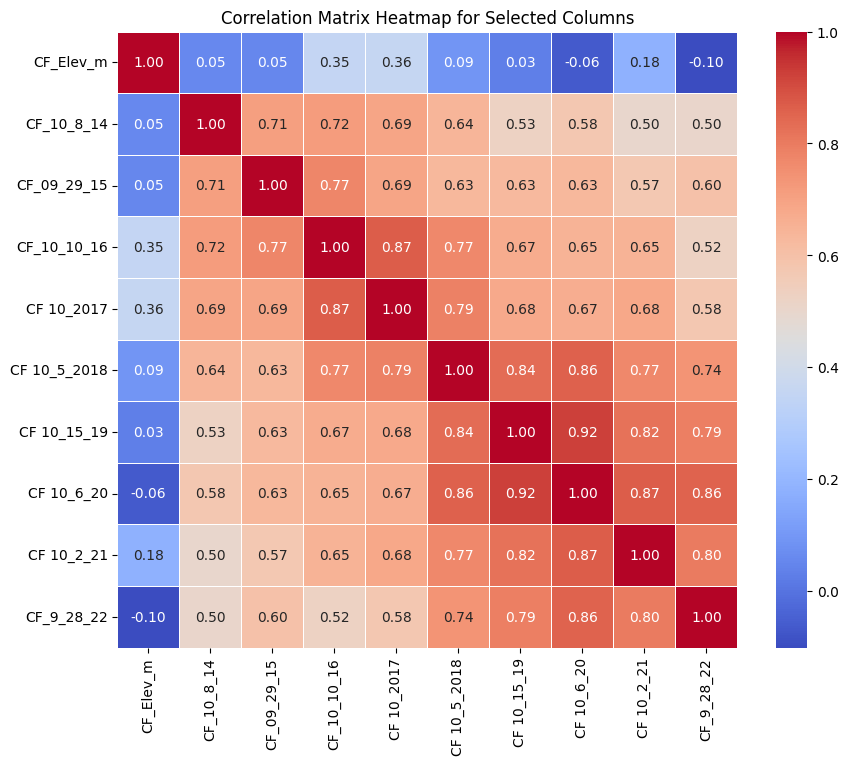

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/Users/Azadeh/CRREL.xlsx'  # Replace with the path to your actual Excel file
sheet_name = 'Creamers'  # Adjust this to the sheet you want to analyze

# Read the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Select the columns of interest
columns_of_interest = [
    'CF_Elev_m', 'CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017',
    'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'
]

# Ensure columns exist in the dataframe
df_selected = df[columns_of_interest]

# Compute correlation matrix for the selected columns
corr_matrix = df_selected.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set title and labels
plt.title('Correlation Matrix Heatmap for Selected Columns')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()


In [63]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
excel_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

gdfs = []

latitude_columns = ['CF_Northing_m', 'FL1_Northing_m', 'FL2_Northing_m', 'PT_Northing_m']
longitude_columns = ['CF_Easting_m', 'FL1_Easting_m', 'FL2_Easting_m', 'PT_Easting_m']

for sheet_name in sheet_names:
    df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    
    lat_col = next((col for col in latitude_columns if col in df.columns), None)
    lon_col = next((col for col in longitude_columns if col in df.columns), None)
    
    if lat_col and lon_col:
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        
        gdf.crs = 'EPSG:32606'
        
        gdf = gdf.to_crs(epsg=4326)
        
        gdf['latitude'] = gdf.geometry.y
        gdf['longitude'] = gdf.geometry.x
        
        gdf['Sheet'] = sheet_name
        
        gdfs.append(gdf)
        print(f"Processed sheet '{sheet_name}' with columns '{lat_col}' and '{lon_col}'.")
    else:
        print(f"Missing required columns in sheet '{sheet_name}'.")

if gdfs:
    all_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    
    if not all_gdf.empty:
        map_center = [all_gdf['latitude'].mean(), all_gdf['longitude'].mean()]
        m = folium.Map(location=map_center, zoom_start=10)

        marker_cluster = MarkerCluster().add_to(m)

        for idx, row in all_gdf.iterrows():
            folium.Marker(
                location=[row['latitude'], row['longitude']], 
                popup=f"Point ID: {row.get('CF_Point', 'N/A')}, Sheet: {row['Sheet']}"
            ).add_to(marker_cluster)

        m.save('frost_probing_locations7.html')
        m
        print("Map created and saved successfully.")
    else:
        print("No valid data to plot.")
else:
    print("No GeoDataFrames created from the sheets.")


Processed sheet 'Creamers' with columns 'CF_Northing_m' and 'CF_Easting_m'.
Processed sheet 'Farmers 1' with columns 'FL1_Northing_m' and 'FL1_Easting_m'.
Processed sheet 'Farmers 2' with columns 'FL2_Northing_m' and 'FL2_Easting_m'.
Processed sheet 'Tunnel' with columns 'PT_Northing_m' and 'PT_Easting_m'.
Map created and saved successfully.


In [56]:
import pandas as pd
import numpy as np

# Load the Excel file
file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
excel_data = pd.ExcelFile(file_path)

def calculate_distance(easting1, northing1, easting2, northing2):
    return np.sqrt((easting2 - easting1) ** 2 + (northing2 - northing1) ** 2)

# Dictionary to store distances and differences for each sheet
distances_dict = {}
differences_dict = {}

# Iterate over each sheet in the Excel file
for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    # Find columns that end with '_Easting_m' and '_Northing_m'
    easting_cols = [col for col in df.columns if col.endswith('_Easting_m')]
    northing_cols = [col for col in df.columns if col.endswith('_Northing_m')]
    
    if len(easting_cols) > 0 and len(northing_cols) > 0:
        easting_col = easting_cols[0]
        northing_col = northing_cols[0]
        
        # Calculate distances between consecutive points
        distances = []
        differences = []
        for i in range(1, len(df)):
            calculated_distance = calculate_distance(
                df[easting_col].iloc[i-1], df[northing_col].iloc[i-1],
                df[easting_col].iloc[i], df[northing_col].iloc[i]
            )
            distances.append(calculated_distance)
            
            # Find the corresponding _Dist_previous_m column
            distance_col = [col for col in df.columns if col.endswith('_Dist_previous_m')]
            if distance_col:
                actual_distance = df[distance_col[0]].iloc[i]
                difference = actual_distance - calculated_distance
                differences.append(difference)
            else:
                differences.append(np.nan)
        
        distances_dict[sheet] = distances
        differences_dict[sheet] = differences

# Convert the distances and differences dictionaries to DataFrames
distances_df = pd.DataFrame({sheet: pd.Series(data) for sheet, data in distances_dict.items()})
differences_df = pd.DataFrame({sheet: pd.Series(data) for sheet, data in differences_dict.items()})

# Concatenate distances and differences DataFrames for better readability
result_df = pd.concat([distances_df.add_suffix('_Calculated_Distance'), differences_df.add_suffix('_Difference')], axis=1)

# Display the DataFrame
print(result_df)

# Save the result to a CSV file
result_df.to_csv('/Users/Azadeh/distances_and_differences3.csv', index=False)

# Print the average distances for each sheet
for sheet, distances in distances_dict.items():
    avg_distance = np.mean(distances)
    print(f"Average calculated Euclidean distance in sheet {sheet}: {avg_distance:.2f} meters")

print("Euclidean Distances and differences have been calculated and saved to 'distances_and_differences3.csv'.")


     Creamers_Calculated_Distance  Farmers 1_Calculated_Distance  \
0                        3.828624                       3.931998   
1                        4.391410                       3.875687   
2                        3.915139                       4.057837   
3                        3.595298                       7.272491   
4                        4.893889                       4.095953   
..                            ...                            ...   
120                      3.939527                            NaN   
121                      3.863510                            NaN   
122                      4.269685                            NaN   
123                      4.042746                            NaN   
124                      4.453246                            NaN   

     Farmers 2_Calculated_Distance  Tunnel_Calculated_Distance  \
0                         3.959297                    4.054110   
1                         4.211515                 

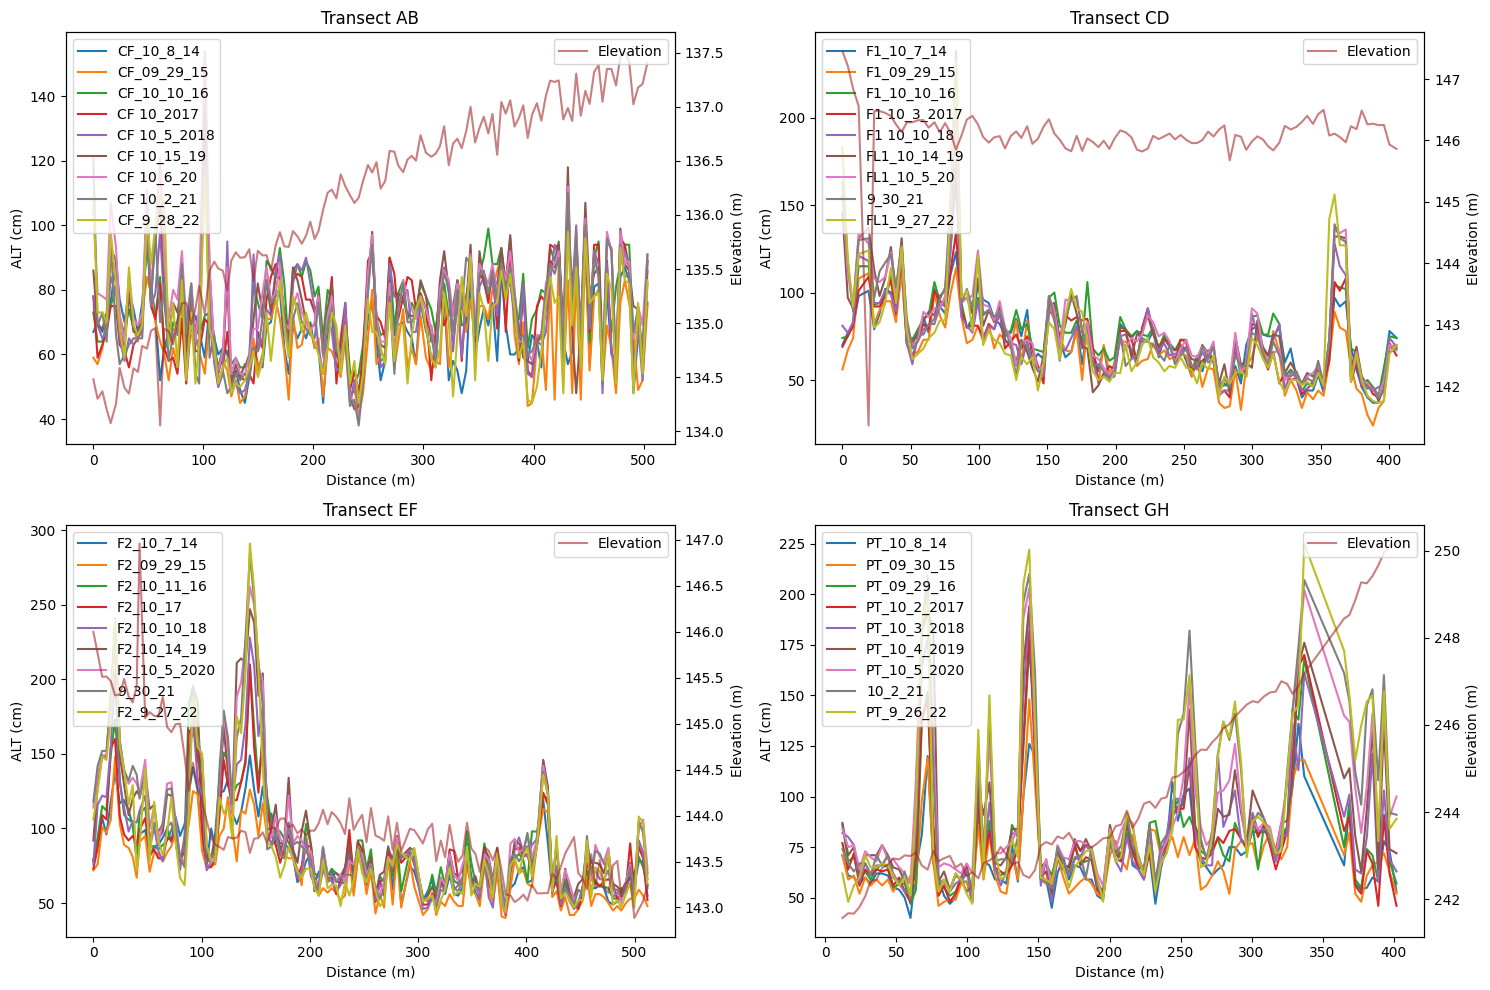

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
titles = ['Transect AB', 'Transect CD', 'Transect EF', 'Transect GH']
distance_cols = ['CF_Dist_transect_m', 'FL1_Dist_transect_m', 'FL2_Dist_transect_m', 'PT_Dist_transect_m']
alt_cols = [
    ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'],
    ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22'],
    ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22'],
    ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
]
elevation_cols = ['CF_Elev_m', 'FL1_Elev_m', 'FL2_Elev_m', 'PT_Elev_m']

def create_subplot(ax, data, distance_col, alt_cols, elevation_col, title):
    data[distance_col] = pd.to_numeric(data[distance_col], errors='coerce')
    
    for col in alt_cols:
        if col in data.columns:
            # Ensure ALT columns are numeric
            data[col] = pd.to_numeric(data[col], errors='coerce')
            ax.plot(data[distance_col], data[col], label=col)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('ALT (cm)')
    ax.set_title(title)

    ax2 = ax.twinx()
    if elevation_col in data.columns:
        data[elevation_col] = pd.to_numeric(data[elevation_col], errors='coerce')
        ax2.plot(data[distance_col], data[elevation_col], color='brown', alpha=0.6, label='Elevation')
    ax2.set_ylabel('Elevation (m)')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, sheet in enumerate(sheets):
    data = pd.read_excel(file_path, sheet_name=sheet)
    distance_col = distance_cols[i]
    elevation_col = elevation_cols[i]
    ax = axs[i // 2, i % 2]
    create_subplot(ax, data, distance_col, alt_cols[i], elevation_col, titles[i])

plt.tight_layout()
plt.show()

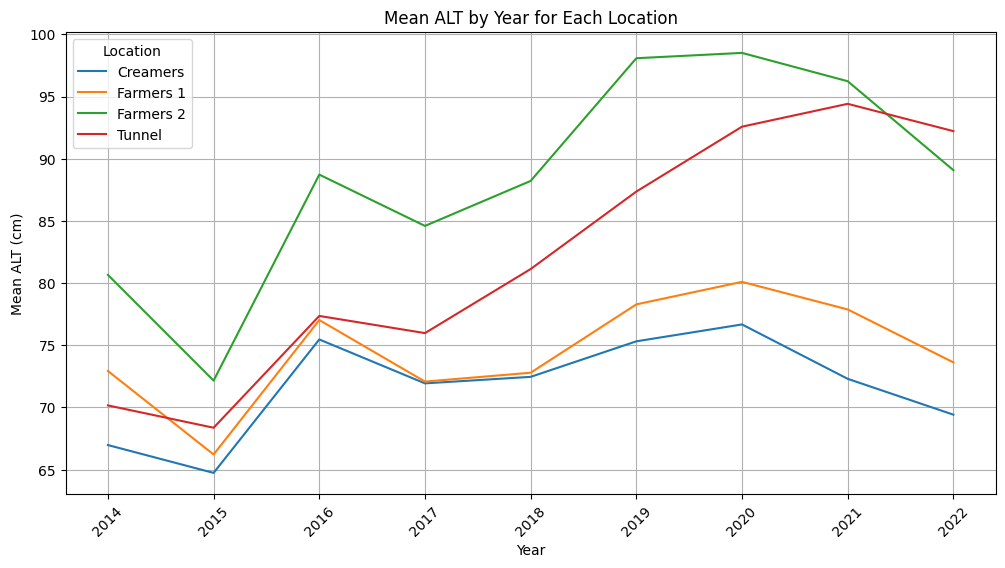

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']

alt_columns_dict = {
    'Creamers': ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'],
    'Farmers 1': ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22'],
    'Farmers 2': ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22'],
    'Tunnel': ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
}

def gather_mean_alt(sheet_name, alt_columns):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    mean_alt_by_year = pd.DataFrame()

    for alt_col in alt_columns:
        year = int(alt_col.split('_')[-1].split()[0][-2:])
        if year < 50:
            year += 2000
        else:
            year += 1900
        
        df['Year'] = year
        df[alt_col] = pd.to_numeric(df[alt_col], errors='coerce')
        year_mean = df.groupby('Year')[alt_col].mean().reset_index()
        year_mean.columns = ['Year', 'Mean_ALT']
        mean_alt_by_year = pd.concat([mean_alt_by_year, year_mean])

    mean_alt_by_year = mean_alt_by_year.groupby('Year')['Mean_ALT'].mean().reset_index()
    mean_alt_by_year['Location'] = sheet_name
    return mean_alt_by_year

all_data = pd.DataFrame()
for sheet in sheets:
    sheet_data = gather_mean_alt(sheet, alt_columns_dict[sheet])
    all_data = pd.concat([all_data, sheet_data])

pivot_data = all_data.pivot(index='Year', columns='Location', values='Mean_ALT')

plt.figure(figsize=(12, 6))
for column in pivot_data:
    plt.plot(pivot_data.index, pivot_data[column], label=column)

plt.title('Mean ALT by Year for Each Location')
plt.xlabel('Year')
plt.ylabel('Mean ALT (cm)')
plt.legend(title='Location')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

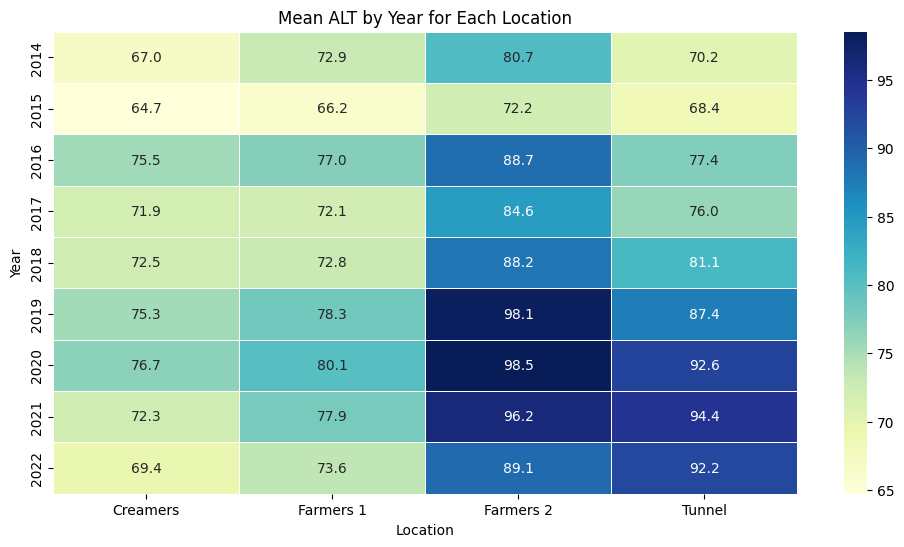

In [89]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Mean ALT by Year for Each Location')
plt.xlabel('Location')
plt.ylabel('Year')
plt.show()

In [97]:
ndvitry = '/Users/Azadeh/Downloads/NDVI'
ndvitrylist = glob.glob(os.path.join(ndvitry, '*'))
sortedlist = sorted(ndvitrylist)
for file in ndvitrylist:
    print(file)

print(f"Total number of files: {len(ndvitrylist)}")

/Users/Azadeh/Downloads/NDVI/CF_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif
Total number of files: 16


In [99]:
xds = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
xds

<xarray.DataArray (band: 1, y: 195, x: 195)> Size: 152kB
[38025 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 4.644e+05 4.644e+05 ... 4.654e+05 4.654e+05
  * y            (y) float64 2kB 7.195e+06 7.195e+06 ... 7.194e+06 7.194e+06
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.004174583158690265
    STATISTICS_MAXIMUM:      0.85118460655212
    STATISTICS_MEAN:         0.71759463681205
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.064611014221186
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

In [100]:
xds.values

array([[[0.7555074 , 0.75271   , 0.7424651 , ..., 0.72710764,
         0.7388886 , 0.7242467 ],
        [0.7586734 , 0.75271   , 0.75771207, ..., 0.7322539 ,
         0.7210951 , 0.72355574],
        [0.7494297 , 0.7417014 , 0.7528174 , ..., 0.63420534,
         0.7210951 , 0.7210951 ],
        ...,
        [0.5251372 , 0.7748266 , 0.7748266 , ..., 0.8163797 ,
         0.8250431 , 0.81616414],
        [0.5251372 , 0.6926813 , 0.8154578 , ..., 0.8361924 ,
         0.81996906, 0.817226  ],
        [0.6926813 , 0.8016052 , 0.8154578 , ..., 0.8269742 ,
         0.8312072 , 0.817226  ]]], dtype=float32)

In [101]:
xds.rio.crs

CRS.from_epsg(32606)

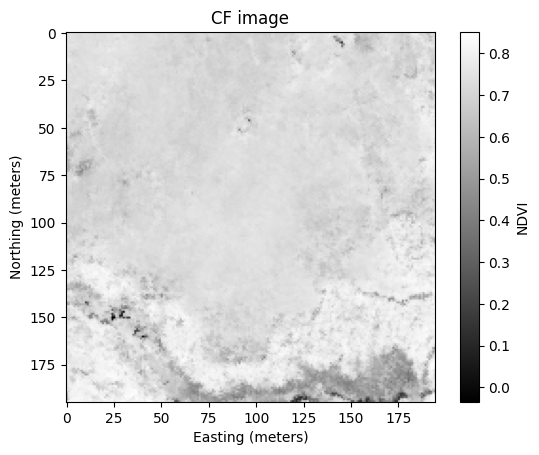

In [175]:
import matplotlib.pyplot as plt
import rasterio as rio
from pyproj import Transformer

plt.imshow(xds[0], cmap='gray')
plt.title('CF image')

plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

plt.colorbar(label='NDVI')

plt.show()


In [103]:
xds.shape[1], xds.shape[2]

(195, 195)

In [105]:
dataset1_utm = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")

In [106]:
print(dataset1_utm.shape)

(1, 195, 195)


In [152]:
import rasterio
dataset = rasterio.open("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
print(dataset.crs)
if dataset.crs == 'EPSG:32606':
    print("The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).")
else:
    print("The dataset is in a different CRS.")


EPSG:32606
The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).


In [158]:
from esda.moran import Moran
from libpysal.weights import lat2W

ndvi_values = ndvi_band.flatten()
w = lat2W(ndvi_band.shape[0], ndvi_band.shape[1])

moran = Moran(ndvi_values, w)
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.816227721109119
P-value: 0.001


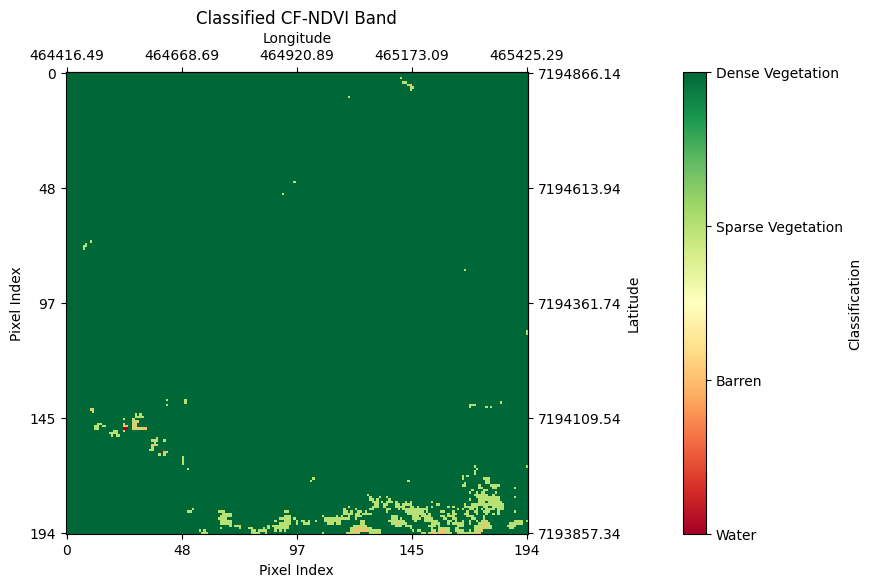

In [84]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform

def pixel_to_geo(pixel_x, pixel_y, transform):
    geo_x, geo_y = rio.transform.xy(transform, pixel_y, pixel_x)
    return geo_x, geo_y

num_ticks = 5 
x_ticks = np.linspace(0, ndvi_band.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, ndvi_band.shape[0] - 1, num_ticks)
x_labels_geo = [round(pixel_to_geo(x, 0, transform)[0], 2) for x in x_ticks]
y_labels_geo = [round(pixel_to_geo(0, y, transform)[1], 2) for y in y_ticks]

classified_pixels = np.zeros_like(ndvi_band)

classified_pixels[ndvi_band < 0] = 1  # Water
classified_pixels[(ndvi_band >= 0) & (ndvi_band < 0.2)] = 2  # Barren
classified_pixels[(ndvi_band >= 0.2) & (ndvi_band < 0.5)] = 3  # Sparse Vegetation
classified_pixels[ndvi_band >= 0.5] = 4  # Dense Vegetation

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(classified_pixels, cmap='RdYlGn', interpolation='none')  #cmap=viridis
ax.set_title('Classified CF-NDVI Band')

cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4], pad=0.2)
cbar.ax.set_yticklabels(['Water', 'Barren', 'Sparse Vegetation', 'Dense Vegetation'])
cbar.set_label('Classification')

ax.set_xticks(x_ticks)
ax.set_xticklabels([int(x) for x in x_ticks])
ax.set_yticks(y_ticks)
ax.set_yticklabels([int(y) for y in y_ticks])

secax_x = ax.secondary_xaxis('top')
secax_x.set_xticks(x_ticks)
secax_x.set_xticklabels(x_labels_geo)
secax_x.set_xlabel('Longitude')

secax_y = ax.secondary_yaxis('right')
secax_y.set_yticks(y_ticks)
secax_y.set_yticklabels(y_labels_geo)
secax_y.set_ylabel('Latitude')

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Pixel Index')

plt.show()


In [23]:
(classified_pixels == 1).sum()

3

In [24]:
(classified_pixels == 2).sum()

37

In [25]:
(classified_pixels == 3).sum()

652

In [26]:
(classified_pixels == 4).sum()

37333

In [75]:
import rasterio as rio
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    pixel_area = abs(transform[0] * transform[4])


In [32]:
import numpy as np
unique_classes, counts = np.unique(classified_pixels, return_counts=True)
areas = counts * pixel_area 

df_classification = pd.DataFrame(list(zip(unique_classes, counts, areas)),
                                 columns=['Class', 'Count', 'Area'])

class_labels = {1: 'Water', 2: 'Barren', 3: 'Sparse Vegetation', 4: 'Dense Vegetation'}
df_classification['Class Label'] = df_classification['Class'].map(class_labels)

total_area = df_classification['Area'].sum()
df_classification['Fraction (%)'] = (df_classification['Area'] / total_area) * 100

print(df_classification[['Class Label', 'Count', 'Area', 'Fraction (%)']])

         Class Label  Count        Area  Fraction (%)
0              Water      3       81.12      0.007890
1             Barren     37     1000.48      0.097304
2  Sparse Vegetation    652    17630.08      1.714661
3   Dense Vegetation  37333  1009484.32     98.180145


In [76]:
import rasterio as rio

# Load the NDVI image
image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    metadata = src.meta
    print("Metadata:", metadata)

    crs = src.crs
    print("Coordinate Reference System (CRS):", crs)

    bounds = src.bounds
    print("Bounds:", bounds)

    transform = src.transform
    print("Transform:", transform)
    
    geo_coords = rio.transform.xy(transform, 0, 0)
    print("Geographical coordinates of pixel (0,0):", geo_coords)

    band_description = src.descriptions[0] if src.descriptions else None
    print("Band Description:", band_description)


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 195, 'height': 195, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(5.2, 0.0, 464413.894,
       0.0, -5.2, 7194868.73508214)}
Coordinate Reference System (CRS): EPSG:32606
Bounds: BoundingBox(left=464413.894, bottom=7193854.73508214, right=465427.894, top=7194868.73508214)
Transform: | 5.20, 0.00, 464413.89|
| 0.00,-5.20, 7194868.74|
| 0.00, 0.00, 1.00|
Geographical coordinates of pixel (0,0): (464416.49399999995, 7194866.135082141)
Band Description: None


GeoDataFrame CRS: epsg:32606


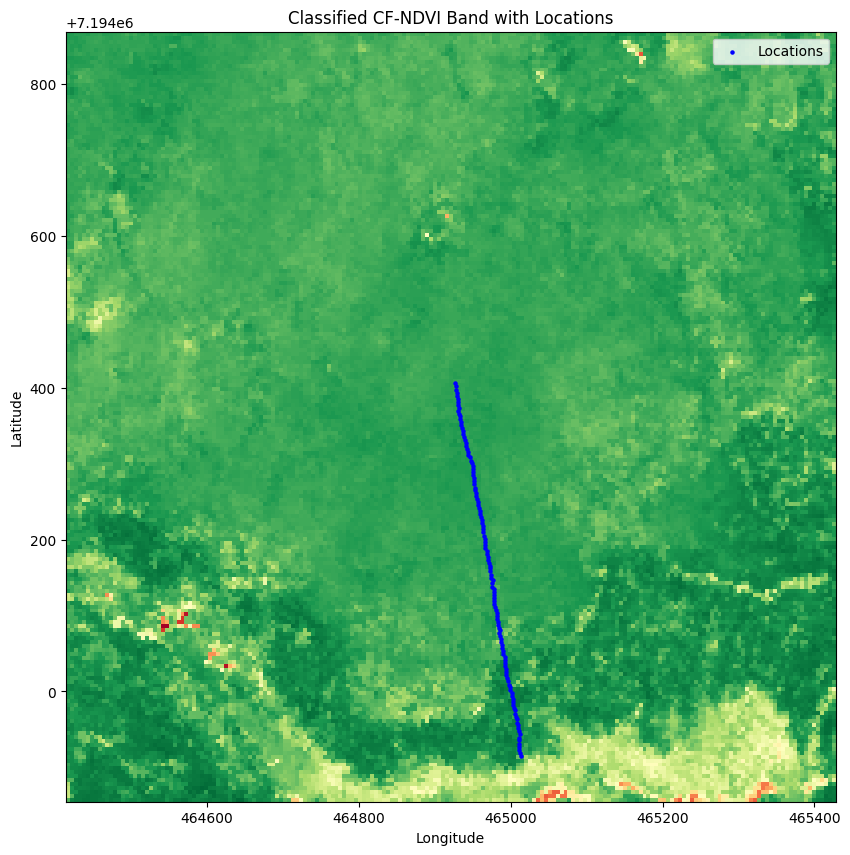

In [86]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

excel_file = "/Users/Azadeh/CRREL_cleaned.xlsx"
coordinates_df = pd.read_excel(excel_file)

latitudes = coordinates_df['CF_Northing_m'].values
longitudes = coordinates_df['CF_Easting_m'].values

transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

def reproject_coordinates(x, y):
    return transformer.transform(x, y)

reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

geometry = [Point(xy) for xy in reprojected_coords]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="epsg:32606")

print("GeoDataFrame CRS:", gdf.crs)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ndvi_band, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified CF-NDVI Band with Locations')

gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('/Users/Azadeh/Downloads/NDVI/NDVI_with_Locations.jpg', format='jpeg')
plt.show()


In [174]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    ndvi_crs = src.crs
    transform = src.transform
    bounds = src.bounds

print("NDVI Image CRS:", ndvi_crs)


NDVI Image CRS: EPSG:32606


In [160]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

reprojected_image_file = "/Users/Azadeh/Downloads/NDVI/reprojected_CFNDVI_image.tif"

with rio.open(image_file) as src:
    dst_crs = 'EPSG:4326'
    
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(reprojected_image_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [161]:
with rio.open(reprojected_image_file) as src:
    ndvi_band_reprojected = src.read(1)
    transform_reprojected = src.transform

geo_coords_reprojected = rio.transform.xy(transform_reprojected, 0, 0)
print("Geographical coordinates of pixel (0,0) after reprojection:", geo_coords_reprojected)

Geographical coordinates of pixel (0,0) after reprojection: (-147.75113244169546, 64.87626478472961)


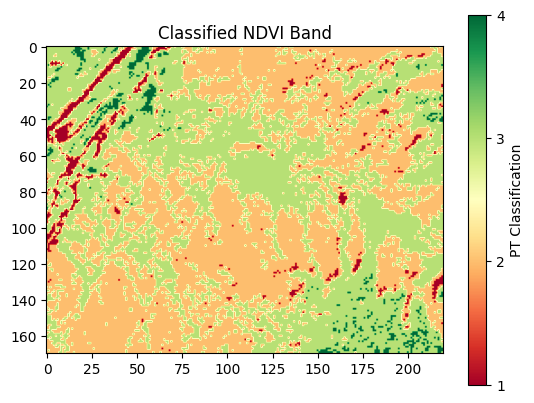

In [89]:
dataset3_utm = rio.open("/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif")
dataset3_utm_np = dataset3_utm.read(1)
classified_pixels = np.zeros_like(dataset3_utm_np)

classified_pixels[dataset3_utm_np < 0] = 1
classified_pixels[(dataset3_utm_np >= 0) & (dataset3_utm_np < 0.2)] = 2
classified_pixels[(dataset3_utm_np >= 0.2) & (dataset3_utm_np < 0.5)] = 3
classified_pixels[dataset3_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='PT Classification')
plt.show()

In [117]:
waterpixels = (classified_pixels == 1).sum()
waterpixels

1096

In [119]:
Barrenpixels = (classified_pixels == 2).sum()
Barrenpixels

18187

In [120]:
Sparsepixels = (classified_pixels == 3).sum()
Sparsepixels

17395

In [121]:
Densepixels = (classified_pixels == 4).sum()
Densepixels

722

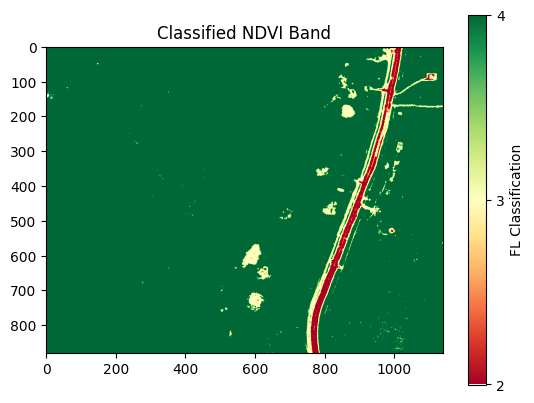

In [90]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

dataset4_utm = rio.open("/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif")

dataset4_utm_np = dataset4_utm.read(1)

classified_pixels = np.zeros_like(dataset4_utm_np)

classified_pixels[dataset4_utm_np < 0] = 1
classified_pixels[(dataset4_utm_np >= 0) & (dataset4_utm_np < 0.2)] = 2
classified_pixels[(dataset4_utm_np >= 0.2) & (dataset4_utm_np < 0.5)] = 3
classified_pixels[dataset4_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[1, 2, 3, 4], label='FL Classification')
plt.show()


Mean: 0.7175946235656738, Median: 0.726357102394104, Std Dev: 0.06461016088724136, Min: -0.03446187824010849, Max: 0.851184606552124


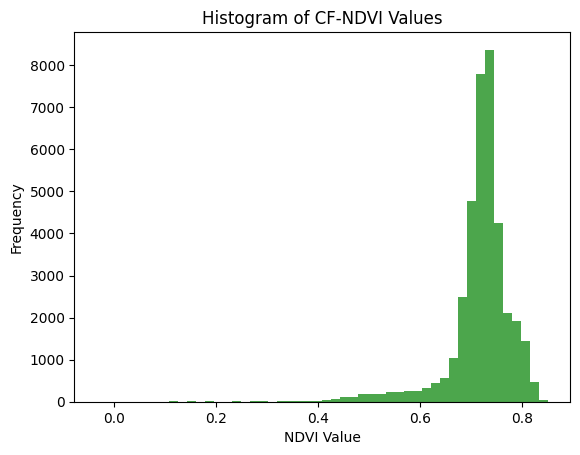

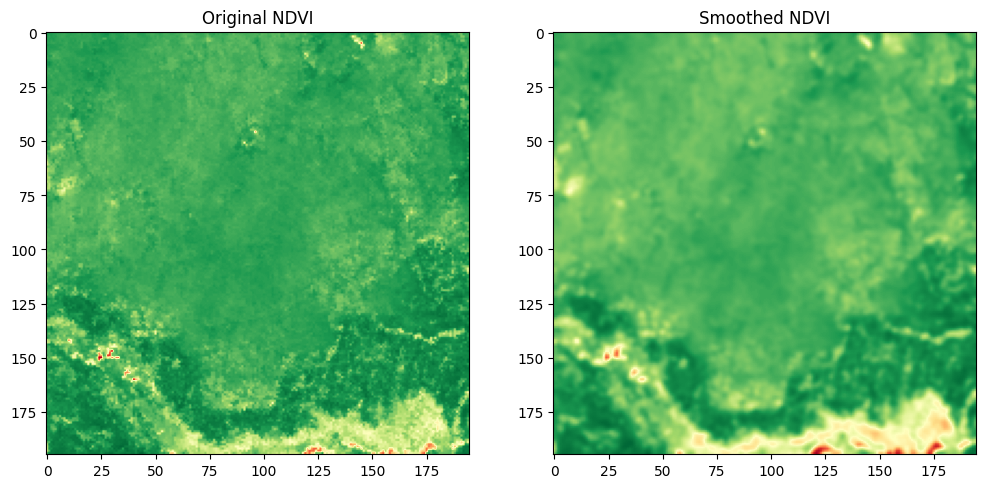

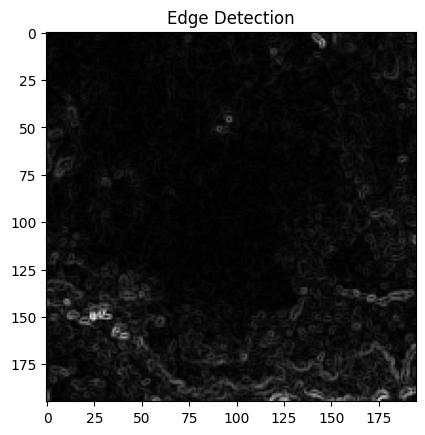

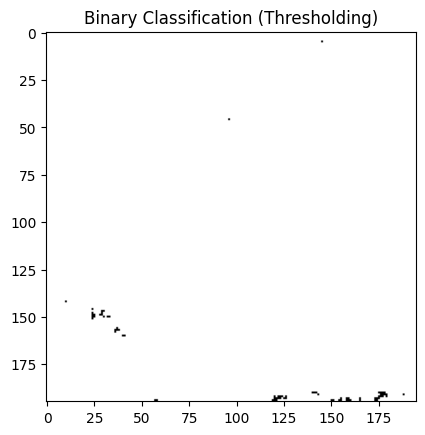

In [134]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import filters

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"

with rasterio.open(image_file) as src:
    band = src.read(1) 

mean_value = np.mean(band)
median_value = np.median(band)
std_dev = np.std(band)
min_value = np.min(band)
max_value = np.max(band)

print(f"Mean: {mean_value}, Median: {median_value}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}")

plt.hist(band.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histogram of CF-NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.show()

smoothed_band = gaussian_filter(band, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(band, cmap='RdYlGn')
ax[0].set_title('Original NDVI')
ax[1].imshow(smoothed_band, cmap='RdYlGn')
ax[1].set_title('Smoothed NDVI')
plt.show()

edges = filters.sobel(band)

plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.show()

threshold = 0.3
binary_classification = (band > threshold).astype(int)

plt.imshow(binary_classification, cmap='gray')
plt.title('Binary Classification (Thresholding)')
plt.show()


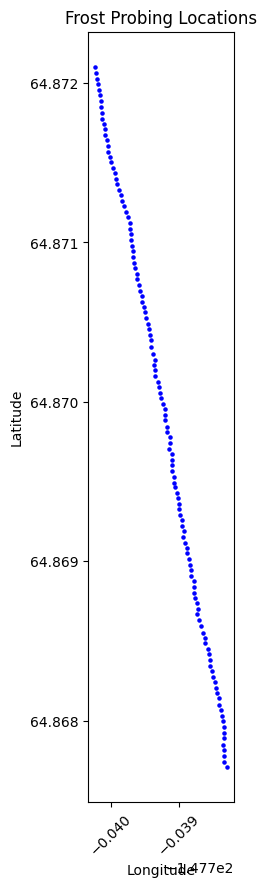

In [182]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

excel_file = '/Users/Azadeh/CRREL_cleaned.xlsx'
df = pd.read_excel(excel_file, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    geometry = [Point(xy) for xy in zip(df['CF_Easting_m'], df['CF_Northing_m'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    gdf.crs = 'EPSG:32606'
    
    gdf = gdf.to_crs(epsg=4326)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, marker='o', color='blue', markersize=5)
    ax.set_title('Frost Probing Locations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.xticks(rotation=45)
    
    plt.savefig('frost_probing_locations.jpg', format='jpeg', dpi=300)
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


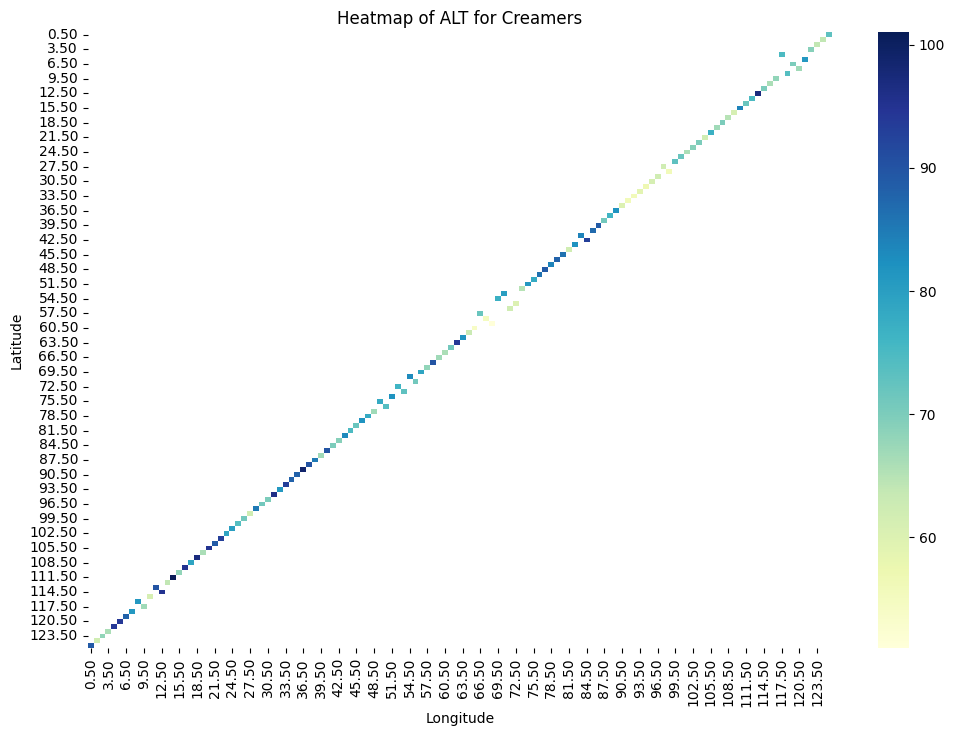

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Transformer

file_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(file_path, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)

    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )

    pivot_table = df.pivot_table(values='CF_10_10_16', index='latitude', columns='longitude')

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot_table, cmap="YlGnBu")

    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], rotation=90)
    ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], rotation=0)

    plt.title('Heatmap of ALT for Creamers')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.savefig('heatmap_ALT_Creamers.jpg', format='jpeg', dpi=300)
    
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


In [14]:
import pandas as pd

# Path to your Excel file
file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

# Read the Excel file with all sheets
excel_data = pd.read_excel(file_path, sheet_name=None)

# Count the number of rows in each sheet
location_counts = {sheet: len(data) for sheet, data in excel_data.items()}

# Print the results
for sheet, count in location_counts.items():
    print(f"The sheet '{sheet}' has {count} locations.")


The sheet 'Creamers' has 126 locations.
The sheet 'Farmers 1' has 101 locations.
The sheet 'Farmers 2' has 126 locations.
The sheet 'Tunnel' has 92 locations.
The sheet 'NaN_Values' has 46 locations.


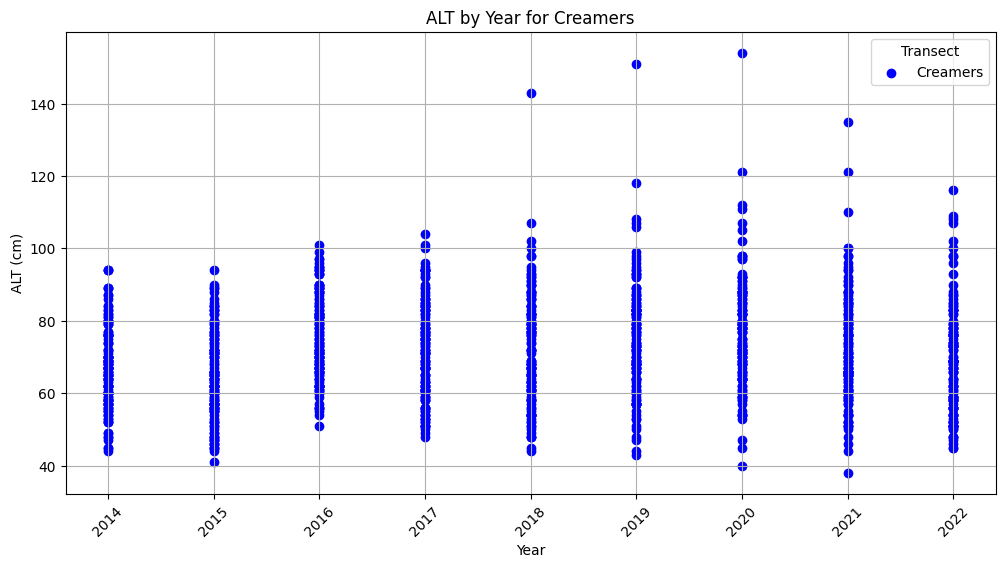

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided Excel file
file_path = '/Users/Azadeh/CRREL.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']

# Manually specify ALT and distance columns for each sheet
columns_dict = {
    'Creamers': {
        'dist': 'CF_Dist_transect_m',
        'alt': ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22']
    },
    'Farmers 1': {
        'dist': 'FL1_Dist_transect_m',
        'alt': ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22']
    },
    'Farmers 2': {
        'dist': 'FL2_Dist_transect_m',
        'alt': ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22']
    },
    'Tunnel': {
        'dist': 'PT_Dist_transect_m',
        'alt': ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
    }
}

# Function to process each sheet and gather ALT data by year
def gather_alt_data(sheet_name, dist_col, alt_columns):
    # Read the sheet into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    alt_data_by_year = pd.DataFrame()

    # Extract year from each ALT column and gather data
    for alt_col in alt_columns:
        # Extract the year from the column name (last two digits)
        year = int(alt_col.split('_')[-1].split()[0][-2:])
        # Assume years are in 2000s for simplicity
        if year < 50:
            year += 2000
        else:
            year += 1900
        
        df['Year'] = year
        df[alt_col] = pd.to_numeric(df[alt_col], errors='coerce')
        alt_data = df[[dist_col, alt_col]].dropna().rename(columns={dist_col: 'Transect_Distance', alt_col: 'ALT'})
        alt_data['Year'] = year
        alt_data['Location'] = sheet_name
        alt_data_by_year = pd.concat([alt_data_by_year, alt_data])

    return alt_data_by_year

# Gather ALT data for each sheet
all_data = pd.DataFrame()
for sheet in sheets:
    sheet_data = gather_alt_data(sheet, columns_dict[sheet]['dist'], columns_dict[sheet]['alt'])
    all_data = pd.concat([all_data, sheet_data])


# Scatter plot for Creamers
plt.figure(figsize=(12, 6))
creamers_data = all_data[all_data['Location'] == 'Creamers']
plt.scatter(creamers_data['Year'], creamers_data['ALT'], color='blue', label='Creamers')
plt.title('ALT by Year for Creamers')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


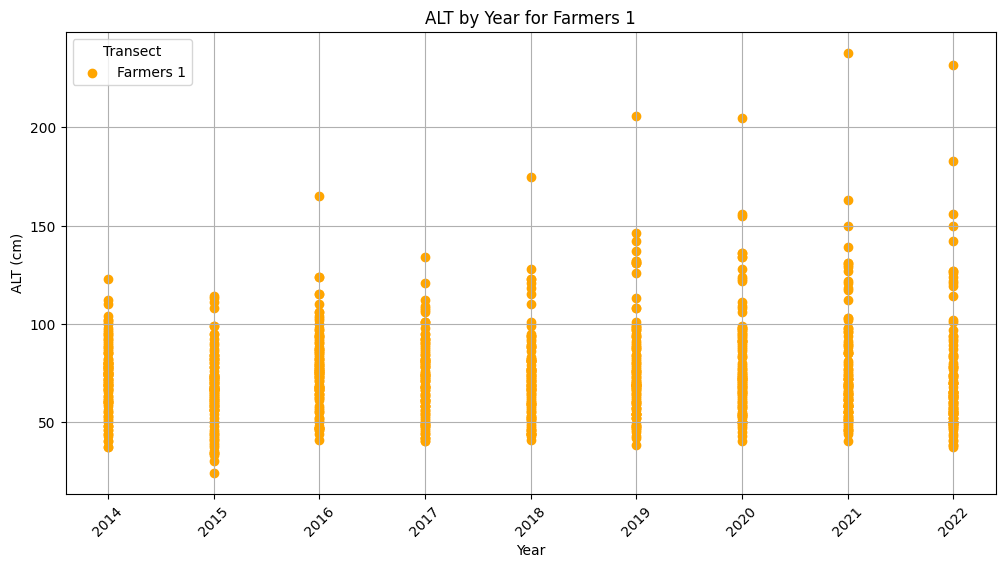

In [69]:
# Scatter plot for Farmers 1
plt.figure(figsize=(12, 6))
farmers1_data = all_data[all_data['Location'] == 'Farmers 1']
plt.scatter(farmers1_data['Year'], farmers1_data['ALT'], color='orange', label='Farmers 1')
plt.title('ALT by Year for Farmers 1')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


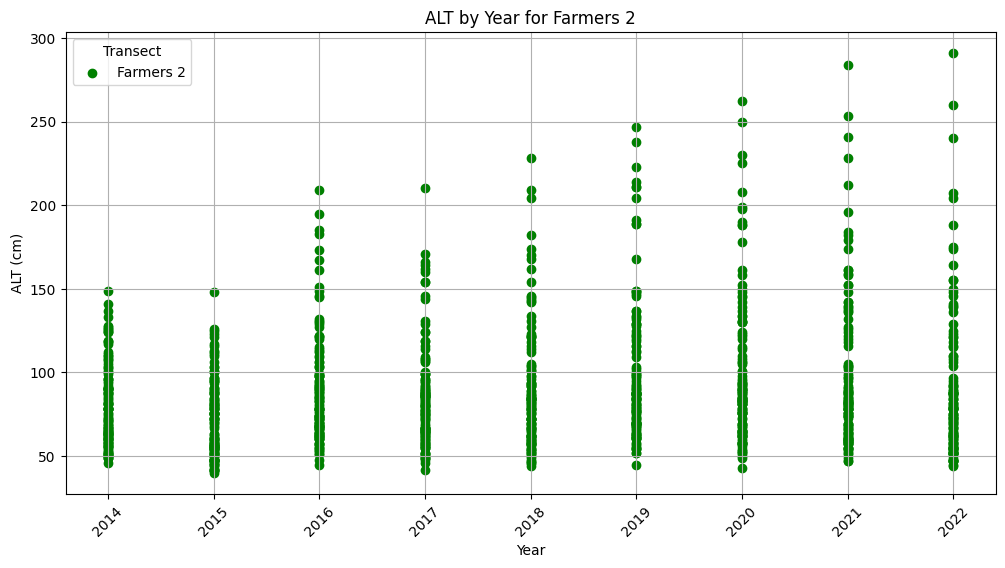

In [70]:
# Scatter plot for Farmers 2
plt.figure(figsize=(12, 6))
farmers2_data = all_data[all_data['Location'] == 'Farmers 2']
plt.scatter(farmers2_data['Year'], farmers2_data['ALT'], color='green', label='Farmers 2')
plt.title('ALT by Year for Farmers 2')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


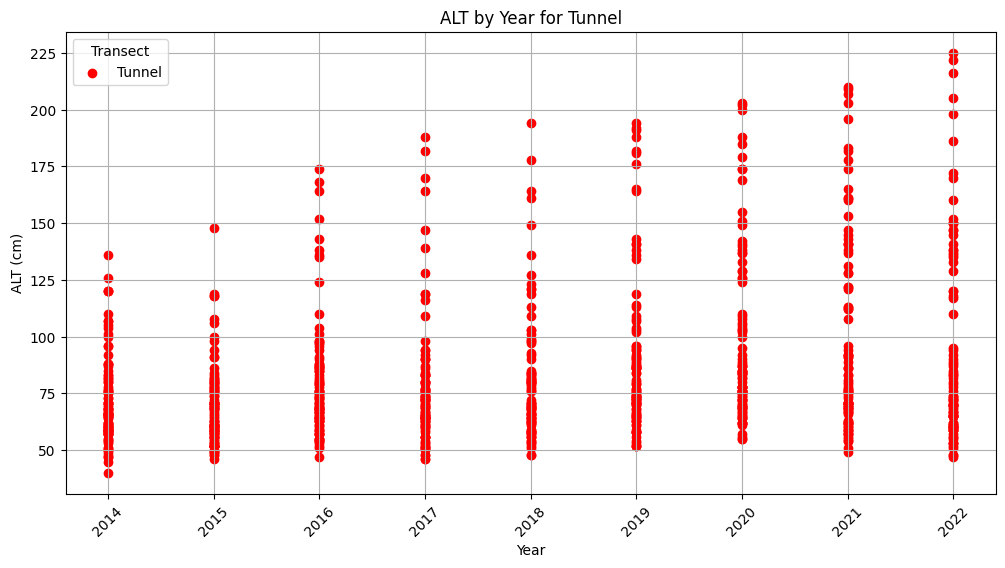

In [71]:
# Scatter plot for Tunnel
plt.figure(figsize=(12, 6))
tunnel_data = all_data[all_data['Location'] == 'Tunnel']
plt.scatter(tunnel_data['Year'], tunnel_data['ALT'], color='red', label='Tunnel')
plt.title('ALT by Year for Tunnel')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


GeoDataFrame CRS: epsg:32606


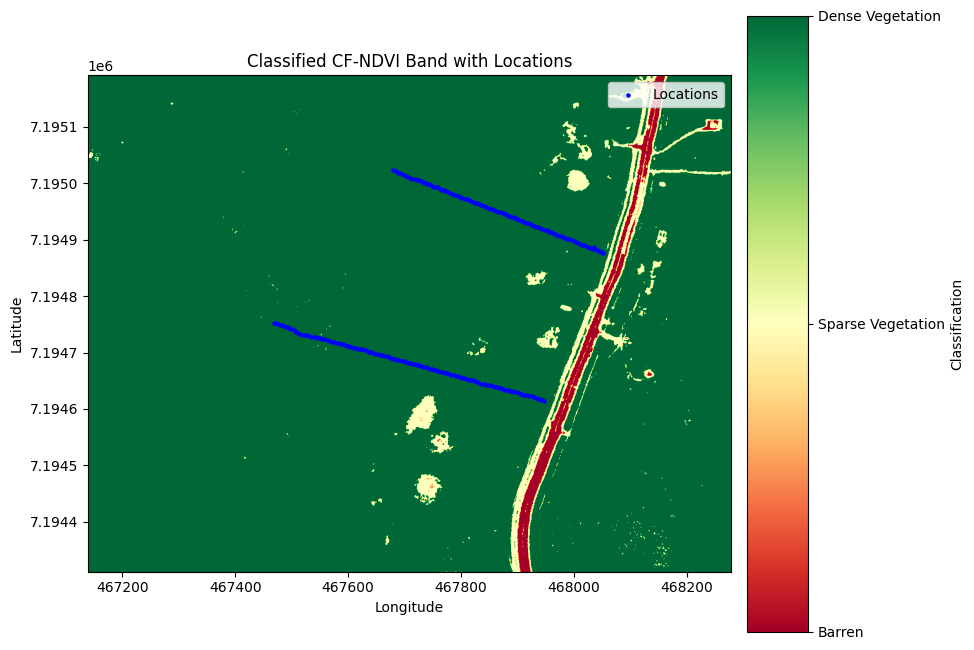

In [12]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer
import numpy as np

# Load the NDVI image
ndvi_file = "/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

# Classify the NDVI values
classified_pixels = np.zeros_like(ndvi_band)
classified_pixels[ndvi_band < 0] = 1  # Water
classified_pixels[(ndvi_band >= 0) & (ndvi_band < 0.2)] = 2  # Barren
classified_pixels[(ndvi_band >= 0.2) & (ndvi_band < 0.5)] = 3  # Sparse Vegetation
classified_pixels[ndvi_band >= 0.5] = 4  # Dense Vegetation

# Load the coordinates from the first and second sheets of the Excel file
excel_file = "/Users/Azadeh/CRREL_cleaned.xlsx"
coordinates_df1 = pd.read_excel(excel_file, sheet_name='Farmers 1')
coordinates_df2 = pd.read_excel(excel_file, sheet_name='Farmers 2')

# Adjusting to ensure correct column names
latitudes1 = coordinates_df1['FL1_Northing_m'].values.flatten()
longitudes1 = coordinates_df1['FL1_Easting_m'].values.flatten()
latitudes2 = coordinates_df2['FL2_Northing_m'].values.flatten()
longitudes2 = coordinates_df2['FL2_Easting_m'].values.flatten()

# Concatenate the coordinates from both sheets
latitudes = np.concatenate([latitudes1, latitudes2])
longitudes = np.concatenate([longitudes1, longitudes2])

transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

def reproject_coordinates(x, y):
    return transformer.transform(x, y)

reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

geometry = [Point(xy) for xy in reprojected_coords]
combined_df = pd.concat([coordinates_df1, coordinates_df2])
gdf = gpd.GeoDataFrame(combined_df, geometry=geometry, crs="epsg:32606")

print("GeoDataFrame CRS:", gdf.crs)

# Plot the NDVI image and locations
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(classified_pixels, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified CF-NDVI Band with Locations')

# Overlay the points
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

# Add colorbar for classification
cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4], shrink=0.8, aspect=10, pad=0.02)
cbar.ax.set_yticklabels(['Water', 'Barren', 'Sparse Vegetation', 'Dense Vegetation'])
cbar.set_label('Classification')

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save plot as JPEG
plt.savefig('/Users/Azadeh/Downloads/NDVI/NDVI_FL_with_Locations.jpg', format='jpeg')
plt.show()


GeoDataFrame CRS: epsg:32606


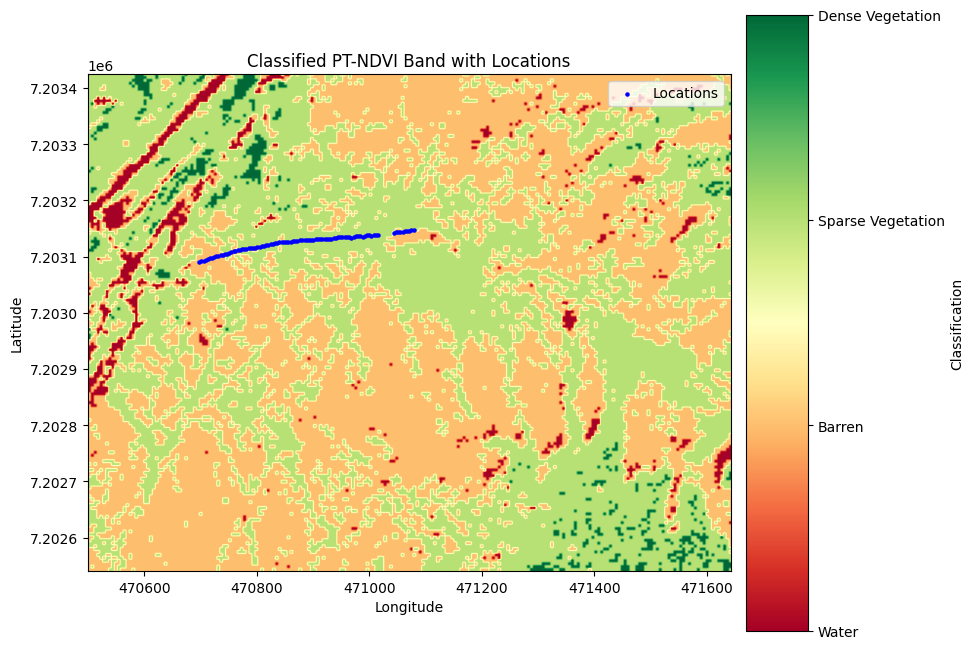

In [75]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer
import numpy as np

# Load the NDVI image
ndvi_file = "/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

# Classify the NDVI values
classified_pixels = np.zeros_like(ndvi_band)
classified_pixels[ndvi_band < 0] = 1  # Water
classified_pixels[(ndvi_band >= 0) & (ndvi_band < 0.2)] = 2  # Barren
classified_pixels[(ndvi_band >= 0.2) & (ndvi_band < 0.5)] = 3  # Sparse Vegetation
classified_pixels[ndvi_band >= 0.5] = 4  # Dense Vegetation

# Load the coordinates from the third sheet of the Excel file
excel_file = "/Users/Azadeh/CRREL_cleaned.xlsx"
coordinates_df = pd.read_excel(excel_file, sheet_name='Tunnel')

# Adjusting to ensure correct column names
latitudes = coordinates_df['PT_Northing_m'].values.flatten()
longitudes = coordinates_df['PT_Easting_m'].values.flatten()

transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

def reproject_coordinates(x, y):
    return transformer.transform(x, y)

reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

geometry = [Point(xy) for xy in reprojected_coords]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="epsg:32606")

print("GeoDataFrame CRS:", gdf.crs)

# Plot the NDVI image and locations
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(classified_pixels, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified PT-NDVI Band with Locations')

# Overlay the points
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

# Add colorbar for classification
cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4], shrink=0.8, aspect=10, pad=0.02)
cbar.ax.set_yticklabels(['Water', 'Barren', 'Sparse Vegetation', 'Dense Vegetation'])
cbar.set_label('Classification')

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save plot as JPEG
plt.savefig('/Users/Azadeh/Downloads/NDVI/NDVI_Tunnel_with_Locations.jpg', format='jpeg')
plt.show()


In [26]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

Creamers = gpd.read_file('/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp')
Creamers.head()

Mean_Layer  Mean_Lay_1  Mean_Lay_2  Mean_Lay_3  Mean_Lay_4  Mean_Lay_5  \
0   -4.297105   -0.444402    0.107883    0.868580   -0.504964    2.182119   
1   -5.608564   -0.765248    0.836958    2.605786   -1.820469    1.362572   
2   -4.691170   -1.355266   -0.019365    5.138265   -0.116034    3.636818   
3    0.330251   -0.507248   -1.215054    6.478460    1.571896    3.436071   
4   -5.657718   -0.135277   -0.452446    4.560037   -1.372984    3.539133   

   Mean_Lay_6  Mean_Lay_7  Mean_Lay_8  Mean_Lay_9  ...      NDVI       CHM  \
0    1.747794    0.868194   -0.040216   -0.182877  ...  0.733303  0.541310   
1    0.602669    0.901093    0.205720    1.196936  ...  0.731732  0.396310   
2    2.206680   -1.246705    0.377954    2.268642  ...  0.743029  1.010550   
3    4.558614   -3.309943   -0.243250    2.789256  ...  0.751909  1.661450   
4    0.867504   -0.419531   -0.206643    1.498612  ...  0.745014  0.552109   

       DSM      DTM  NDVI_STD   CHM_STD   DSM_STD   DTM_STD   Pred_Veg  \
0  139.108  138.567  0.007667  0.654383  0.000000  0.000000        Fen   
1  138.970  138.574  0.006758  0.657662  0.657669  0.084299        Fen   
2  139.609  138.599  0.014515  1.317420  0.662122  0.083998  Shrubland   
3  140.250  138.588  0.013598  1.672590  1.275890  0.119287  Shrubland   
4  139.241  138.689  0.008976  0.663455  1.623540  0.117372  Shrubland   

                                            geometry  
0  POLYGON Z ((464434.694 7194868.735 0.000, 4644...  
1  POLYGON Z ((464471.094 7194868.735 0.000, 4645...  
2  POLYGON Z ((464523.094 7194868.735 0.000, 4645...  
3  POLYGON Z ((464549.094 7194868.735 0.000, 4645...  
4  POLYGON Z ((464564.694 7194868.735 0.000, 4645...  

[5 rows x 30 columns]

In [27]:
Creamers.dtypes

Mean_Layer     float64
Mean_Lay_1     float64
Mean_Lay_2     float64
Mean_Lay_3     float64
Mean_Lay_4     float64
Mean_Lay_5     float64
Mean_Lay_6     float64
Mean_Lay_7     float64
Mean_Lay_8     float64
Mean_Lay_9     float64
Standard_d     float64
Standard_1     float64
Standard_2     float64
Standard_3     float64
Standard_4     float64
Standard_5     float64
Standard_6     float64
Standard_7     float64
Standard_8     float64
Standard_9     float64
NDVI           float64
CHM            float64
DSM            float64
DTM            float64
NDVI_STD       float64
CHM_STD        float64
DSM_STD        float64
DTM_STD        float64
Pred_Veg        object
geometry      geometry
dtype: object

In [28]:
Creamers.shape

(5205, 30)

In [29]:
Creamers.columns

Index(['Mean_Layer', 'Mean_Lay_1', 'Mean_Lay_2', 'Mean_Lay_3', 'Mean_Lay_4',
       'Mean_Lay_5', 'Mean_Lay_6', 'Mean_Lay_7', 'Mean_Lay_8', 'Mean_Lay_9',
       'Standard_d', 'Standard_1', 'Standard_2', 'Standard_3', 'Standard_4',
       'Standard_5', 'Standard_6', 'Standard_7', 'Standard_8', 'Standard_9',
       'NDVI', 'CHM', 'DSM', 'DTM', 'NDVI_STD', 'CHM_STD', 'DSM_STD',
       'DTM_STD', 'Pred_Veg', 'geometry'],
      dtype='object')

In [ ]:
Creamers['area'] = Creamers['geometry'].area
Creamers.head()

In [36]:
Creamers.crs

<Projected CRS: EPSG:32606>
Name: WGS 84 / UTM zone 6N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 150°W and 144°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-150.0, 0.0, -144.0, 84.0)
Coordinate Operation:
- name: UTM zone 6N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
counties_reproject = counties.to_crs('EPSG:4326')
counties_reproject.crs

In [ ]:
Creamers.nlargest(n=10, columns='area')

In [ ]:
Creamers['perimeter'] = Creamers['geometry'].length
Creamers.head()

In [ ]:
Creamers['centroid'] = Creamers['geometry'].centroid
Creamers.head()

In [43]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

# Check the geometry type of each row and extract coordinates only for point geometries
gdf['latitude'] = gdf.geometry.apply(lambda geom: geom.y if geom.geom_type == 'Point' else None)
gdf['longitude'] = gdf.geometry.apply(lambda geom: geom.x if geom.geom_type == 'Point' else None)

# Calculate area for polygon geometries
gdf['area'] = gdf.geometry.apply(lambda geom: geom.area if geom.geom_type == 'Polygon' else None)

# Calculate centroid for polygon geometries
gdf['centroid'] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type == 'Polygon' else None)

# Extract centroid coordinates
gdf['centroid_latitude'] = gdf['centroid'].apply(lambda point: point.y if point else None)
gdf['centroid_longitude'] = gdf['centroid'].apply(lambda point: point.x if point else None)

# Select relevant columns and add row number
gdf['row_number'] = gdf.index + 1
selected_columns = ['row_number', 'NDVI', 'Pred_Veg', 'geometry', 'latitude', 'longitude', 'area', 'centroid_latitude', 'centroid_longitude']

# Create a new dataframe with selected columns
output_df = gdf[selected_columns]

# Save to CSV
csv_output_path = '/Users/Azadeh/Downloads/Creamers_Field_with_lat_lon_and_area.csv'
output_df.to_csv(csv_output_path, index=False)

print("CSV file created at:", csv_output_path)


CSV file created at: /Users/Azadeh/Downloads/Creamers_Field_with_lat_lon_and_area.csv


In [45]:
import geopandas as gpd
from shapely.geometry import Point

# Load the shapefile
shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

# Calculate centroid for polygon geometries
gdf['centroid'] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type == 'Polygon' else None)

# Calculate distances
gdf['centroid_latitude'] = gdf['centroid'].apply(lambda point: point.y if point else None)
gdf['centroid_longitude'] = gdf['centroid'].apply(lambda point: point.x if point else None)

# Reproject to a projected CRS for accurate distance calculation
gdf_reprojected = gdf.to_crs('EPSG:32610')

# Get the first polygon centroid
first_centroid = gdf_reprojected.iloc[0].centroid

# Calculate distance of the first centroid to all other centroids
gdf_reprojected['dist_from_first_centroid'] = gdf_reprojected.centroid.distance(first_centroid) / 1000

# Calculate the pairwise distances between centroids
distances = gdf_reprojected.centroid.apply(lambda point: gdf_reprojected.centroid.distance(point) / 1000)

# Save pairwise distances to a CSV file
distance_df = distances.apply(pd.Series)
distance_csv_path = '/Users/Azadeh/Downloads/Centroid_Distances.csv'
distance_df.to_csv(distance_csv_path, index=False)

# Select relevant columns and add row number
gdf_reprojected['row_number'] = gdf_reprojected.index + 1
selected_columns = ['row_number', 'NDVI', 'Pred_Veg', 'geometry', 'centroid_latitude', 'centroid_longitude', 'dist_from_first_centroid']

# Create a new dataframe with selected columns
output_df = gdf_reprojected[selected_columns]

# Save to CSV
csv_output_path = '/Users/Azadeh/Downloads/Creamers_Field_with_distances.csv'
output_df.to_csv(csv_output_path, index=False)

print("CSV file with centroid distances created at:", csv_output_path)
print("CSV file with pairwise distances created at:", distance_csv_path)


CSV file with centroid distances created at: /Users/Azadeh/Downloads/Creamers_Field_with_distances.csv
CSV file with pairwise distances created at: /Users/Azadeh/Downloads/Centroid_Distances.csv


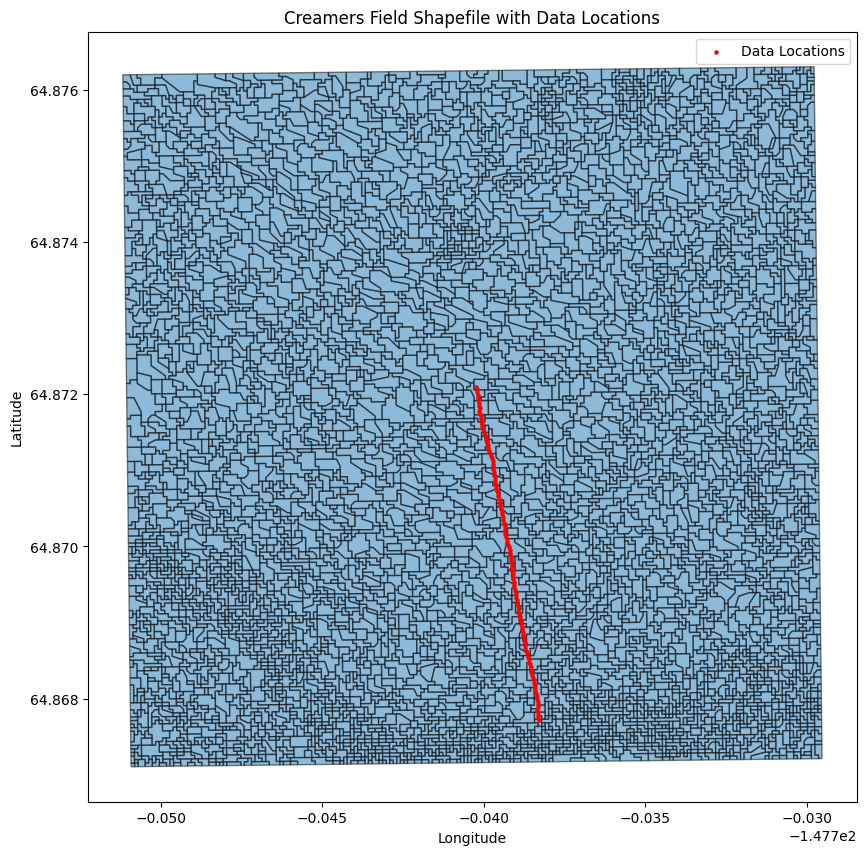

In [91]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer

# Load the shapefile and the Excel file
shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
excel_file_path = '/Users/Azadeh/CRREL.xlsx'
gdf = gpd.read_file(shapefile_path)
df = pd.read_excel(excel_file_path, sheet_name='Creamers')

# Check for required columns
if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    # Reproject coordinates
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)
    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )
    
    # Convert to GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="epsg:4326")
    
    # Reproject and plot
    gdf = gdf.to_crs("epsg:4326")
    ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    locations_gdf.plot(ax=ax, color='red', markersize=5, label='Data Locations')
    
    plt.title('Creamers Field Shapefile with Data Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.savefig('/Users/Azadeh/creamers_field_plot.jpg', format='jpeg')

    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")

Index(['Mean_Layer', 'Mean_Lay_1', 'Mean_Lay_2', 'Mean_Lay_3', 'Mean_Lay_4',
       'Mean_Lay_5', 'Mean_Lay_6', 'Mean_Lay_7', 'Mean_Lay_8', 'Mean_Lay_9',
       'Standard_d', 'Standard_1', 'Standard_2', 'Standard_3', 'Standard_4',
       'Standard_5', 'Standard_6', 'Standard_7', 'Standard_8', 'Standard_9',
       'NDVI', 'CHM', 'DSM', 'DTM', 'NDVI_STD', 'CHM_STD', 'DSM_STD',
       'DTM_STD', 'Pred_Veg', 'geometry'],
      dtype='object')


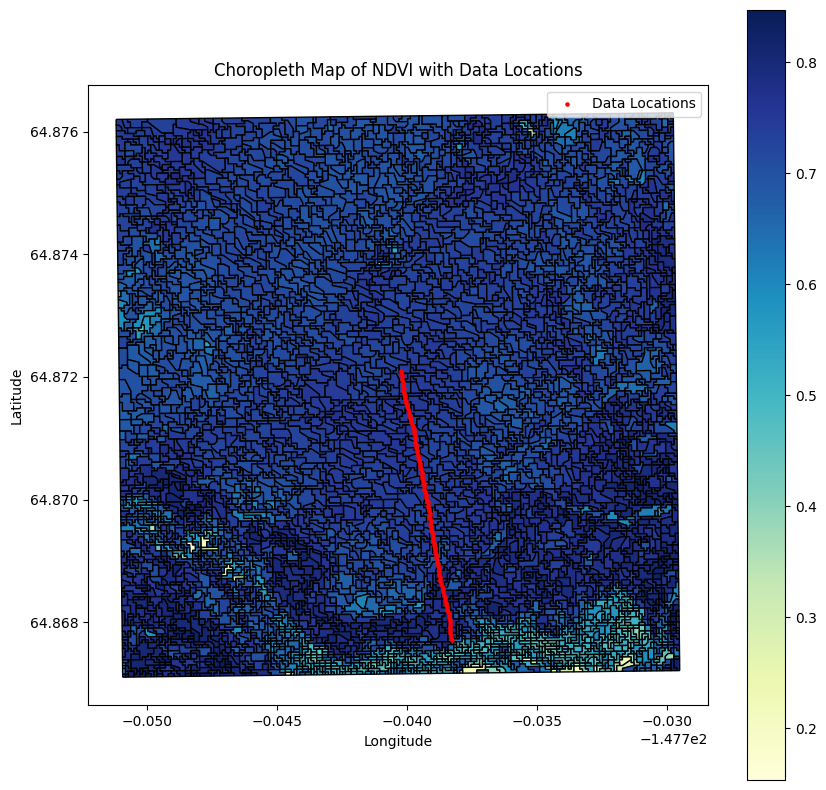

In [93]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer

# Load the shapefile
shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

# Check available columns
print(gdf.columns)

# Select the column to visualize (for example, 'NDVI')
# Ensure the selected column is numeric
gdf['NDVI'] = gdf['NDVI'].astype(float)

# Load the Excel file
excel_file_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_file_path, sheet_name='Creamers')

# Check for required columns
if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    # Reproject coordinates
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)
    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )
    
    # Convert to GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="epsg:4326")
    
    # Reproject the shapefile to match the NDVI raster CRS
    gdf = gdf.to_crs("epsg:4326")
    
    # Create the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='NDVI', ax=ax, legend=True, cmap='YlGnBu', edgecolor='k')
    
    # Plot data locations
    locations_gdf.plot(ax=ax, color='red', markersize=5, label='Data Locations')
    
    # Add title and labels
    plt.title('Choropleth Map of NDVI with Data Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Save the plot as a JPEG file
    plt.savefig('/Users/Azadeh/creamers_field_ndvi_locations_plot.jpg', format='jpeg')
    
    # Show the plot
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


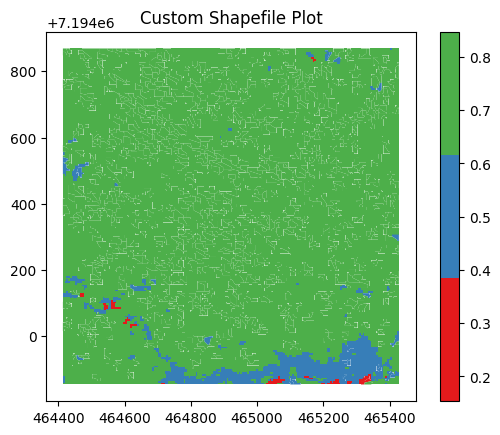

In [74]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Plot with a custom colormap
cmap = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
gdf.plot(column='NDVI', cmap=cmap, legend=True)
plt.title('Custom Shapefile Plot')
plt.show()


   Mean_Layer  Mean_Lay_1  Mean_Lay_2  Mean_Lay_3  Mean_Lay_4  Mean_Lay_5  \
0   -4.297105   -0.444402    0.107883    0.868580   -0.504964    2.182119   
1   -5.608564   -0.765248    0.836958    2.605786   -1.820469    1.362572   
2   -4.691170   -1.355266   -0.019365    5.138265   -0.116034    3.636818   
3    0.330251   -0.507248   -1.215054    6.478460    1.571896    3.436071   
4   -5.657718   -0.135277   -0.452446    4.560037   -1.372984    3.539133   

   Mean_Lay_6  Mean_Lay_7  Mean_Lay_8  Mean_Lay_9  ...      NDVI       CHM  \
0    1.747794    0.868194   -0.040216   -0.182877  ...  0.733303  0.541310   
1    0.602669    0.901093    0.205720    1.196936  ...  0.731732  0.396310   
2    2.206680   -1.246705    0.377954    2.268642  ...  0.743029  1.010550   
3    4.558614   -3.309943   -0.243250    2.789256  ...  0.751909  1.661450   
4    0.867504   -0.419531   -0.206643    1.498612  ...  0.745014  0.552109   

       DSM      DTM  NDVI_STD   CHM_STD   DSM_STD   DTM_STD   Pred_V

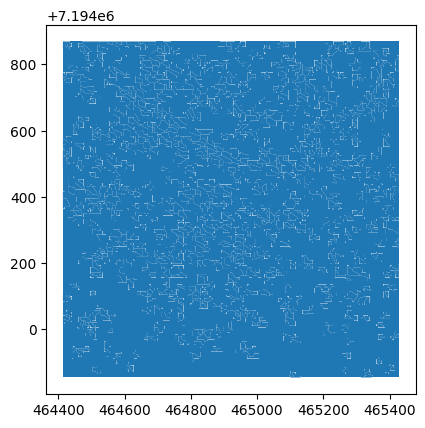

In [78]:
import geopandas as gpd

# Load the shapefile
gdf = gpd.read_file('/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp')

# Inspect the first few rows
print(gdf.head())

# Get information about the GeoDataFrame
print(gdf.info())

# Plot the shapefile
gdf.plot()
plt.show()


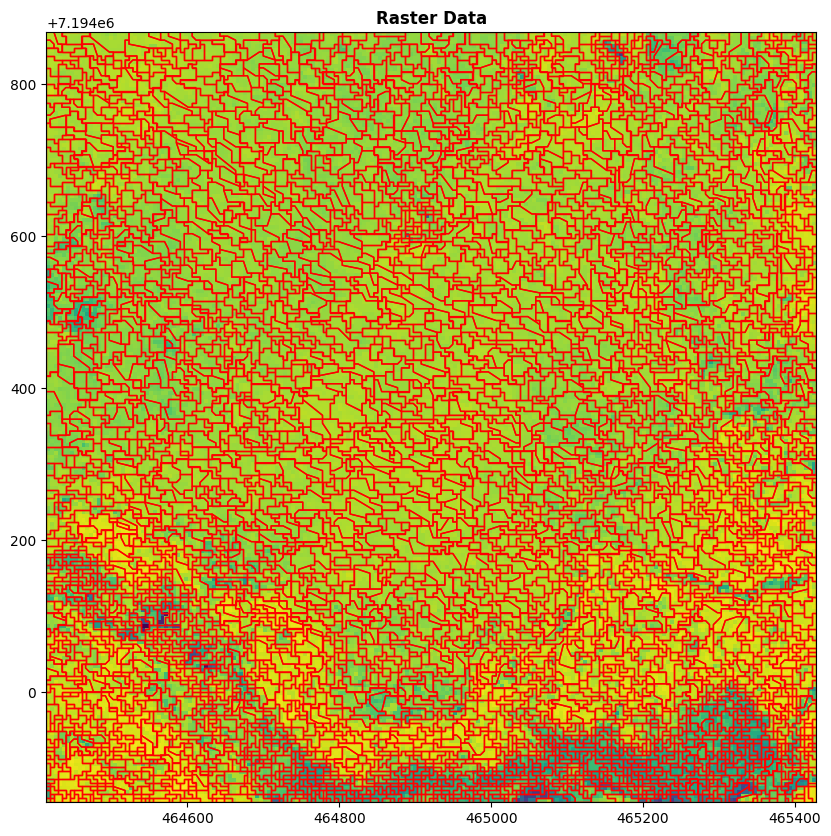

In [2]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import numpy as np

# Load shapefile
shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

# Plot the raster data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
show(raster, ax=ax, title='Raster Data')
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()


In [5]:
# Calculate zonal statistics for ALT
stats = zonal_stats(shapefile_path, tiff_path, stats="mean", band=1)

# Add the ALT data to the GeoDataFrame
gdf['ALT'] = [stat['mean'] for stat in stats]

# Display the GeoDataFrame with ALT
print(gdf)


      Mean_Layer  Mean_Lay_1  Mean_Lay_2  Mean_Lay_3  Mean_Lay_4  Mean_Lay_5  \
0      -4.297105   -0.444402    0.107883    0.868580   -0.504964    2.182119   
1      -5.608564   -0.765248    0.836958    2.605786   -1.820469    1.362572   
2      -4.691170   -1.355266   -0.019365    5.138265   -0.116034    3.636818   
3       0.330251   -0.507248   -1.215054    6.478460    1.571896    3.436071   
4      -5.657718   -0.135277   -0.452446    4.560037   -1.372984    3.539133   
...          ...         ...         ...         ...         ...         ...   
5200    6.373671    1.853331   -3.304161   -3.904727    5.221700   -1.749701   
5201    8.731154    2.353787   -8.788379    2.703801    5.251112   -3.170351   
5202   11.407386    1.268163  -11.392674    9.143537    7.659246   -5.801601   
5203   12.950951    1.096006   -7.327321    3.001219    4.355651   -5.997097   
5204   13.442052    1.348233   -9.979535    8.013359    5.976688   -5.123062   

      Mean_Lay_6  Mean_Lay_7  Mean_Lay_

   CF_Easting_m  CF_Northing_m   longitude     latitude
0    465013.469    7193915.511  465013.469  7193915.511
1    465011.682    7193918.897  465011.682  7193918.897
2    465011.427    7193923.281  465011.427  7193923.281
3    465011.460    7193927.196  465011.460  7193927.196
4    465010.849    7193930.739  465010.849  7193930.739


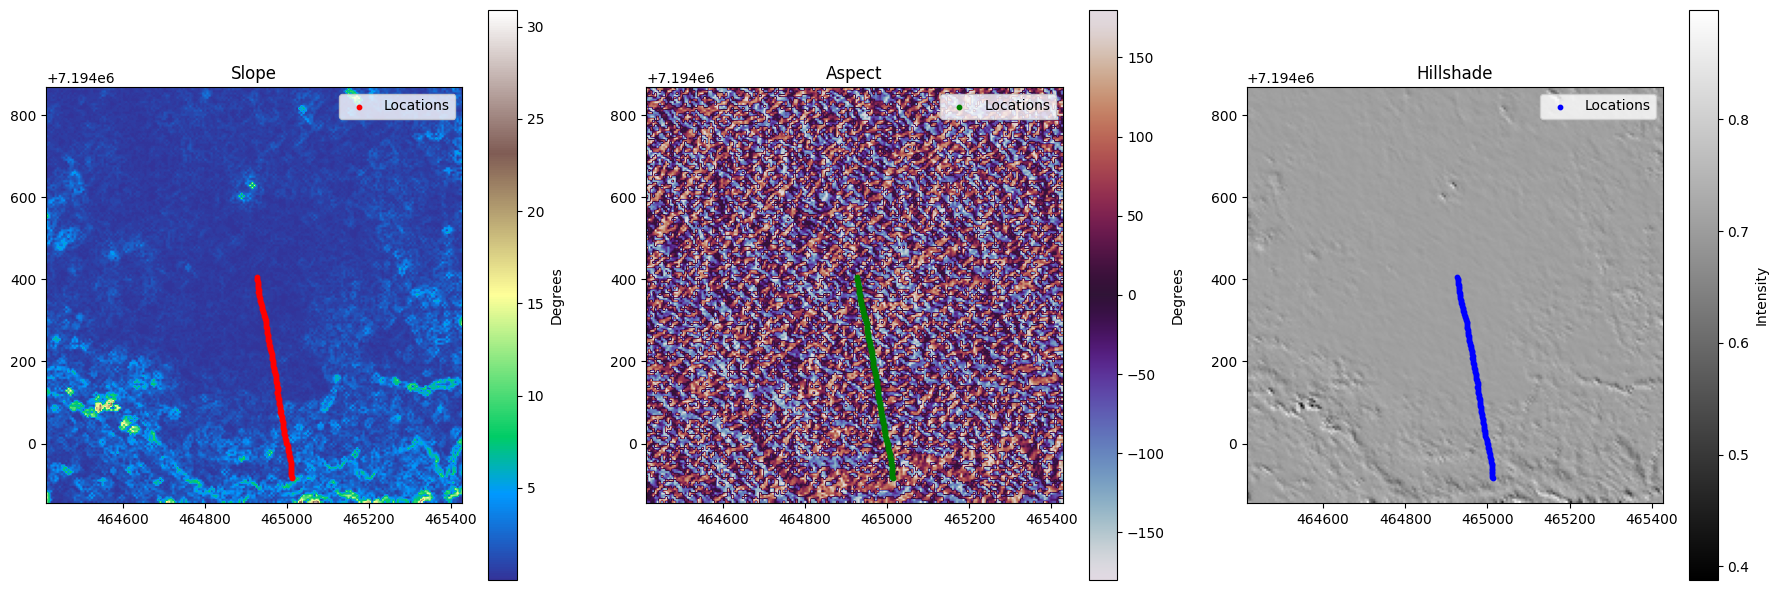

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import rasterio
import numpy as np

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

# Function to calculate slope
def calculate_slope(elevation):
    x, y = np.gradient(elevation)
    slope = np.arctan(np.sqrt(x**2 + y**2))
    return np.degrees(slope)

# Function to calculate aspect
def calculate_aspect(elevation):
    x, y = np.gradient(elevation)
    aspect = np.arctan2(-x, y)
    return np.degrees(aspect)

# Function to calculate hillshade
def calculate_hillshade(elevation, azimuth=315, angle_altitude=45):
    x, y = np.gradient(elevation)
    slope = np.pi/2 - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuth_rad = np.deg2rad(azimuth)
    altitude_rad = np.deg2rad(angle_altitude)
    shaded = np.sin(altitude_rad) * np.sin(slope) + np.cos(altitude_rad) * np.cos(slope) * np.cos((azimuth_rad - np.pi/2) - aspect)
    return shaded

# Read elevation data from the raster
elevation = raster.read(1)

# Calculate slope, aspect, and hillshade
slope = calculate_slope(elevation)
aspect = calculate_aspect(elevation)
hillshade = calculate_hillshade(elevation)

# Load Excel data
excel_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_path, sheet_name='Creamers')

# Check for required columns
if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    # Reproject coordinates
    transformer = Transformer.from_crs("epsg:32606", raster.crs.to_string(), always_xy=True)
    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )
    
    # Verify the transformed coordinates
    print(df[['CF_Easting_m', 'CF_Northing_m', 'longitude', 'latitude']].head())
    
    # Convert to GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=raster.crs.to_string())
    
    # Plot the results with legends and locations
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    raster_extent = [raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top]

    im1 = ax1.imshow(slope, cmap='terrain', extent=raster_extent)
    ax1.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='red', label='Locations', s=10)
    ax1.set_title('Slope')
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.set_label('Degrees')
    ax1.legend()
    
    im2 = ax2.imshow(aspect, cmap='twilight', extent=raster_extent)
    ax2.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='green', label='Locations', s=10)
    ax2.set_title('Aspect')
    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.set_label('Degrees')
    ax2.legend()
    
    im3 = ax3.imshow(hillshade, cmap='gray', extent=raster_extent)
    ax3.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='blue', label='Locations', s=10)
    ax3.set_title('Hillshade')
    cbar3 = fig.colorbar(im3, ax=ax3)
    cbar3.set_label('Intensity')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


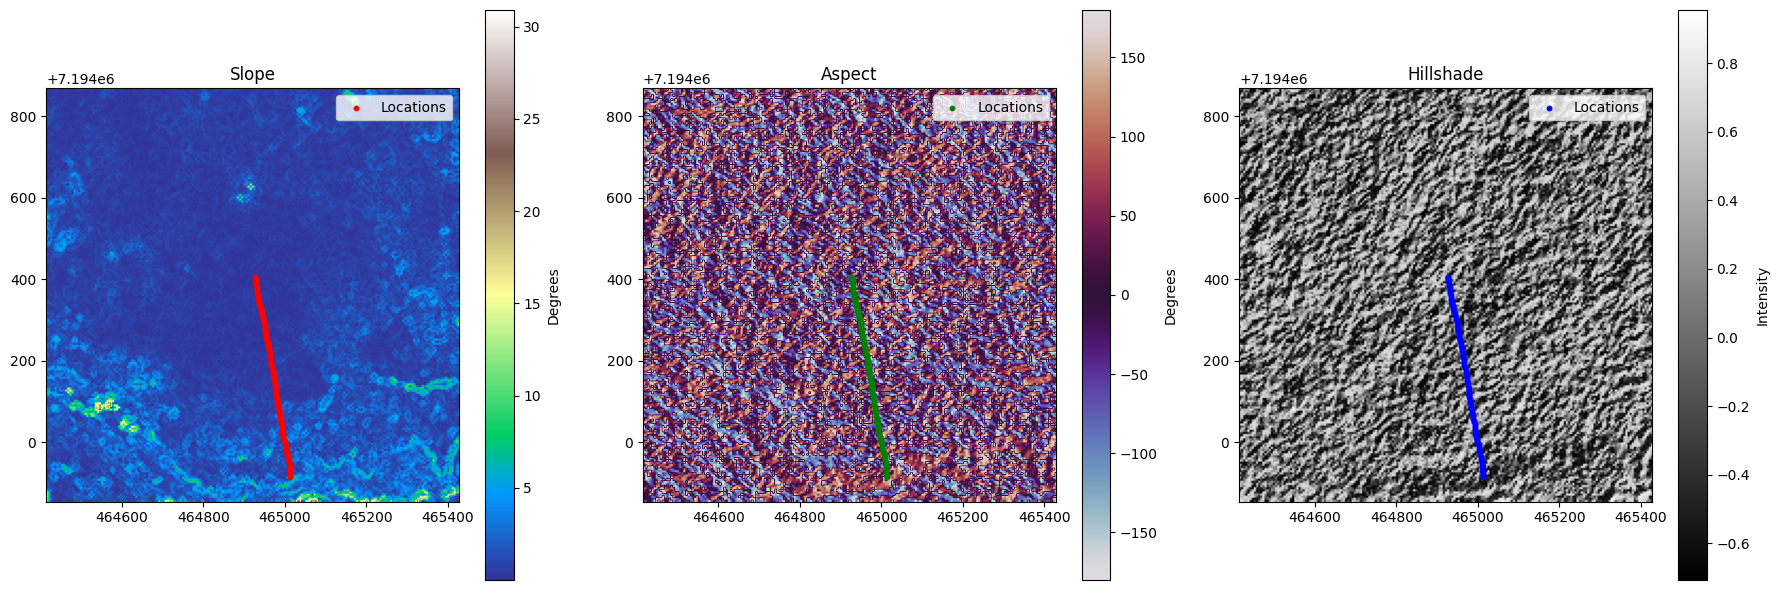

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import rasterio
import numpy as np
import geopandas as gpd

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

# Load Excel data
excel_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_path, sheet_name='Creamers')

# Transform coordinates from UTM to WGS84
transformer = Transformer.from_crs("epsg:32606", raster.crs.to_string(), always_xy=True)
df['longitude'], df['latitude'] = transformer.transform(df['CF_Easting_m'].values, df['CF_Northing_m'].values)

# Create GeoDataFrame for locations
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=raster.crs.to_string())

# Read elevation data from the raster
elevation = raster.read(1)

# Calculate slope, aspect, and hillshade
slope = np.degrees(np.arctan(np.sqrt(np.gradient(elevation)[0]**2 + np.gradient(elevation)[1]**2)))
aspect = np.degrees(np.arctan2(-np.gradient(elevation)[0], np.gradient(elevation)[1]))
hillshade = np.sin(np.deg2rad(45)) * np.sin(np.arctan(np.sqrt(np.gradient(elevation)[0]**2 + np.gradient(elevation)[1]**2))) + np.cos(np.deg2rad(45)) * np.cos(np.arctan(np.sqrt(np.gradient(elevation)[0]**2 + np.gradient(elevation)[1]**2))) * np.cos(np.deg2rad(315) - np.arctan2(-np.gradient(elevation)[0], np.gradient(elevation)[1]))

# Plot the results with legends and locations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Define raster extent
raster_extent = [raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top]

# Plot slope
ax1.imshow(slope, cmap='terrain', extent=raster_extent)
ax1.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='red', label='Locations', s=10)
ax1.set_title('Slope')
fig.colorbar(ax1.imshow(slope, cmap='terrain', extent=raster_extent), ax=ax1, label='Degrees')
ax1.legend()

# Plot aspect
ax2.imshow(aspect, cmap='twilight', extent=raster_extent)
ax2.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='green', label='Locations', s=10)
ax2.set_title('Aspect')
fig.colorbar(ax2.imshow(aspect, cmap='twilight', extent=raster_extent), ax=ax2, label='Degrees')
ax2.legend()

# Plot hillshade
ax3.imshow(hillshade, cmap='gray', extent=raster_extent)
ax3.scatter(locations_gdf.geometry.x, locations_gdf.geometry.y, color='blue', label='Locations', s=10)
ax3.set_title('Hillshade')
fig.colorbar(ax3.imshow(hillshade, cmap='gray', extent=raster_extent), ax=ax3, label='Intensity')
ax3.legend()

plt.tight_layout()
plt.show()


Invalid geometries:      CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  longitude  latitude     geometry  
126         NaN         NaN         NaN        NaN       NaN  POI

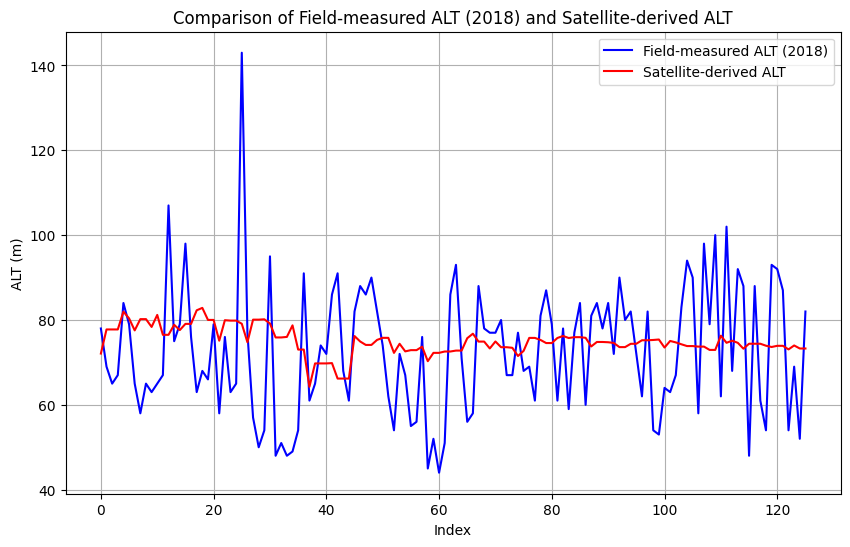

In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import rasterio
import numpy as np
from rasterstats import zonal_stats

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

# Load Excel data
excel_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_path, sheet_name='Creamers')

# Transform coordinates from UTM to WGS84
transformer = Transformer.from_crs("epsg:32606", raster.crs.to_string(), always_xy=True)
df['longitude'], df['latitude'] = transformer.transform(df['CF_Easting_m'].values, df['CF_Northing_m'].values)

# Create GeoDataFrame for locations
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=raster.crs.to_string())

# Check for invalid geometries
invalid_geometries = locations_gdf[locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna()]
print("Invalid geometries:", invalid_geometries)

# Remove invalid geometries if any
locations_gdf = locations_gdf[~(locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna())]

# Ensure all geometries are valid
locations_gdf = locations_gdf[locations_gdf.is_valid]

# Calculate zonal statistics for ALT
stats = zonal_stats(locations_gdf, tiff_path, stats="mean", band=1)

# Check if stats is calculated properly
print("Zonal stats:", stats)

# Add satellite ALT to the GeoDataFrame and scale it
locations_gdf['satellite_ALT'] = [stat['mean'] * 100 for stat in stats]

# Ensure both datasets contain necessary columns and clean them
field_data_2018 = df[df['CF 10_5_2018'].notna() & df['geometry'].notna()]
field_data_2018 = field_data_2018[['CF 10_5_2018', 'geometry']].reset_index(drop=True)
locations_gdf = locations_gdf[locations_gdf['satellite_ALT'].notna()].reset_index(drop=True)

# Ensure lengths match
min_length = min(len(locations_gdf), len(field_data_2018))
locations_gdf = locations_gdf.iloc[:min_length]
field_data_2018 = field_data_2018.iloc[:min_length]

# Debugging: print the first few values of both ALT datasets to verify correctness
print("Field-measured ALT (2018):", field_data_2018['CF 10_5_2018'].head())
print("Satellite-derived ALT:", locations_gdf['satellite_ALT'].head())

# Plot both the field-measured ALT and satellite-derived ALT
plt.figure(figsize=(10, 6))
plt.plot(field_data_2018['CF 10_5_2018'].values, 'b-', label='Field-measured ALT (2018)')
plt.plot(locations_gdf['satellite_ALT'].values, 'r-', label='Satellite-derived ALT')
plt.xlabel('Index')
plt.ylabel('ALT (m)')
plt.title('Comparison of Field-measured ALT (2018) and Satellite-derived ALT')
plt.legend()
plt.grid(True)
plt.show()


Invalid geometries:      CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  longitude  latitude     geometry  
126         NaN         NaN         NaN        NaN       NaN  POI

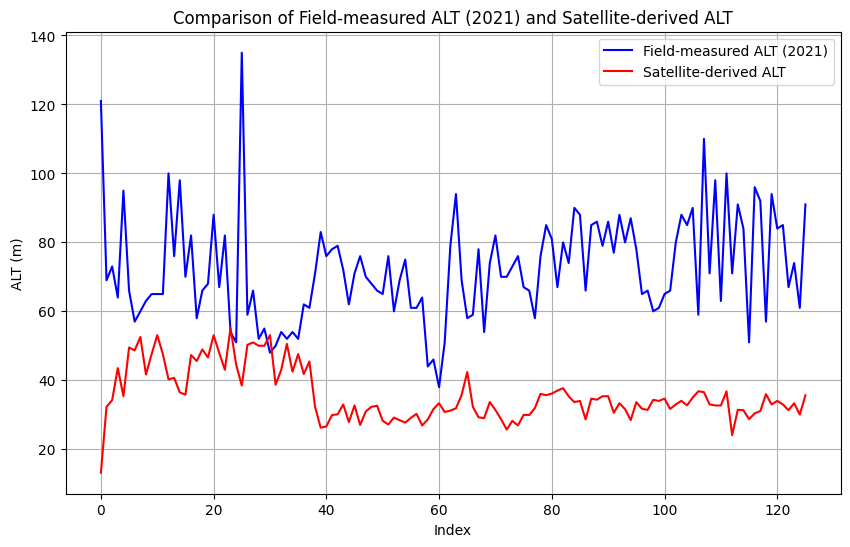

In [46]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import rasterio
import numpy as np
from rasterstats import zonal_stats

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif'
raster = rasterio.open(tiff_path)

# Load Excel data
excel_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_path, sheet_name='Creamers')

# Transform coordinates from UTM to WGS84
transformer = Transformer.from_crs("epsg:32606", raster.crs.to_string(), always_xy=True)
df['longitude'], df['latitude'] = transformer.transform(df['CF_Easting_m'].values, df['CF_Northing_m'].values)

# Create GeoDataFrame for locations
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=raster.crs.to_string())

# Check for invalid geometries
invalid_geometries = locations_gdf[locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna()]
print("Invalid geometries:", invalid_geometries)

# Remove invalid geometries if any
locations_gdf = locations_gdf[~(locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna())]

# Ensure all geometries are valid
locations_gdf = locations_gdf[locations_gdf.is_valid]

# Calculate zonal statistics for ALT
stats = zonal_stats(locations_gdf, tiff_path, stats="mean", band=1)

# Check if stats is calculated properly
print("Zonal stats:", stats)

# Add satellite ALT to the GeoDataFrame and scale it
locations_gdf['satellite_ALT'] = [stat['mean'] * 100 for stat in stats]

# Ensure both datasets contain necessary columns and clean them
field_data_2021 = df[df['CF 10_2_21'].notna() & df['geometry'].notna()]
field_data_2021 = field_data_2021[['CF 10_2_21', 'geometry']].reset_index(drop=True)
locations_gdf = locations_gdf[locations_gdf['satellite_ALT'].notna()].reset_index(drop=True)

# Ensure lengths match
min_length = min(len(locations_gdf), len(field_data_2021))
locations_gdf = locations_gdf.iloc[:min_length]
field_data_2021 = field_data_2021.iloc[:min_length]

# Debugging: print the first few values of both ALT datasets to verify correctness
print("Field-measured ALT (2021):", field_data_2021['CF 10_2_21'].head())
print("Satellite-derived ALT:", locations_gdf['satellite_ALT'].head())

# Plot both the field-measured ALT and satellite-derived ALT
plt.figure(figsize=(10, 6))
plt.plot(field_data_2021['CF 10_2_21'].values, 'b-', label='Field-measured ALT (2021)')
plt.plot(locations_gdf['satellite_ALT'].values, 'r-', label='Satellite-derived ALT')
plt.xlabel('Index')
plt.ylabel('ALT (m)')
plt.title('Comparison of Field-measured ALT (2021) and Satellite-derived ALT')
plt.legend()
plt.grid(True)
plt.show()


Invalid geometries:      CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  longitude  latitude     geometry  
126         NaN         NaN         NaN        NaN       NaN  POI

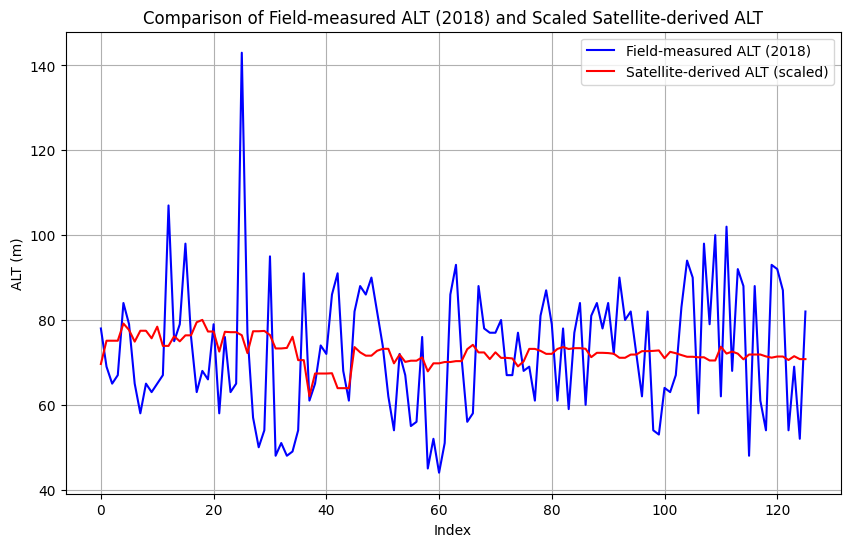

In [48]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import rasterio
import numpy as np
from rasterstats import zonal_stats

# Load raster data
tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

# Load Excel data
excel_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_path, sheet_name='Creamers')

# Transform coordinates from UTM to WGS84
transformer = Transformer.from_crs("epsg:32606", raster.crs.to_string(), always_xy=True)
df['longitude'], df['latitude'] = transformer.transform(df['CF_Easting_m'].values, df['CF_Northing_m'].values)

# Create GeoDataFrame for locations
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=raster.crs.to_string())

# Check for invalid geometries
invalid_geometries = locations_gdf[locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna()]
print("Invalid geometries:", invalid_geometries)

# Remove invalid geometries if any
locations_gdf = locations_gdf[~(locations_gdf['geometry'].is_empty | locations_gdf['geometry'].isna())]

# Ensure all geometries are valid
locations_gdf = locations_gdf[locations_gdf.is_valid]

# Calculate zonal statistics for ALT
stats = zonal_stats(locations_gdf, tiff_path, stats="mean", band=1)

# Check if stats is calculated properly
print("Zonal stats:", stats)

# Add satellite ALT to the GeoDataFrame without scaling
locations_gdf['satellite_ALT'] = [stat['mean'] for stat in stats]

# Ensure both datasets contain necessary columns and clean them
field_data_2018 = df[df['CF 10_5_2018'].notna() & df['geometry'].notna()]
field_data_2018 = field_data_2018[['CF 10_5_2018', 'geometry']].reset_index(drop=True)
locations_gdf = locations_gdf[locations_gdf['satellite_ALT'].notna()].reset_index(drop=True)

# Ensure lengths match
min_length = min(len(locations_gdf), len(field_data_2018))
locations_gdf = locations_gdf.iloc[:min_length]
field_data_2018 = field_data_2018.iloc[:min_length]

# Calculate the scaling factor
scaling_factor = field_data_2018['CF 10_5_2018'].mean() / locations_gdf['satellite_ALT'].mean()

# Scale the satellite-derived ALT values
locations_gdf['satellite_ALT'] = locations_gdf['satellite_ALT'] * scaling_factor

# Debugging: print the first few values of both ALT datasets to verify correctness
print("Field-measured ALT (2018):", field_data_2018['CF 10_5_2018'].head())
print("Satellite-derived ALT (scaled):", locations_gdf['satellite_ALT'].head())

# Plot both the field-measured ALT and scaled satellite-derived ALT
plt.figure(figsize=(10, 6))
plt.plot(field_data_2018['CF 10_5_2018'].values, 'b-', label='Field-measured ALT (2018)')
plt.plot(locations_gdf['satellite_ALT'].values, 'r-', label='Satellite-derived ALT (scaled)')
plt.xlabel('Index')
plt.ylabel('ALT (m)')
plt.title('Comparison of Field-measured ALT (2018) and Scaled Satellite-derived ALT')
plt.legend()
plt.grid(True)
plt.show()
